# Kepler Exoplanet Classifier

**Table of Contents**
- [Load & Initial Overview](#Load-&-Initial-Overview)
- [Outliers](#Outliers)
- [Label creation & alignment](#Label-creation-&-alignment)
- [Modeling Setup](#Modeling-Setup)
- [MLP Model](#MLP)
- [RF Model](#RANDOM-FOREST)
- [KNN Model](#KNN)
- [Models Comparison](#Models-Comparison)
- [Threshold analysis and Confusion Matrices](#Threshold-analysis-and-Confusion-Matrices)
- [Misclassification analysis](#Misclassification-Analysis)

In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [2]:
import warnings
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"   

## Hardware

In [3]:
import json, platform
info = {
    "os": platform.platform(),
    "machine": platform.machine(),
    "processor_str": platform.processor(),
}

# cores & freq
try:
    import psutil
    info["physical_cores"] = psutil.cpu_count(logical=False)
    info["logical_cores"]  = psutil.cpu_count(logical=True)
    f = psutil.cpu_freq()
    if f: info.update({"freq_current_MHz": round(f.current,1), "freq_max_MHz": round(f.max,1)})
except Exception:
    pass

# detailed CPU brand + flags (optional)
try:
    import cpuinfo  # pip install py-cpuinfo
    ci = cpuinfo.get_cpu_info()
    info["brand"] = ci.get("brand_raw")
    info["arch"]  = ci.get("arch_string_raw")
    info["hz"]    = ci.get("hz_actual_friendly")
    flags = ci.get("flags", [])
    keep = {"avx512f","avx2","avx","fma","sse4_2","neon"}
    info["simd_flags"] = sorted(set(flags) & keep)
except Exception:
    info["note"] = "Install 'py-cpuinfo' for brand/flags: pip install py-cpuinfo psutil"

print(json.dumps(info, indent=2, ensure_ascii=False))


{
  "os": "macOS-15.6.1-arm64-arm-64bit",
  "machine": "arm64",
  "processor_str": "arm",
  "physical_cores": 14,
  "logical_cores": 14,
  "freq_current_MHz": 4056,
  "freq_max_MHz": 4056,
  "brand": "Apple M3 Max",
  "arch": "arm64",
  "hz": null,
  "simd_flags": []
}


In [4]:
from cpuinfo import get_cpu_info; import psutil
print(get_cpu_info().get("brand_raw"))
print("RAM GB:", round(psutil.virtual_memory().total/1024**3,1))


Apple M3 Max
RAM GB: 36.0


# Load & Initial Overview

link to data - https://www.kaggle.com/datasets/nasa/kepler-exoplanet-search-results

In [5]:
df = pd.read_csv('data/cumulative.csv')
df.head(10)


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,6,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
6,7,10872983,K00756.02,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
7,8,10872983,K00756.03,Kepler-228 b,CONFIRMED,CANDIDATE,0.992,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
8,9,6721123,K00114.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,...,-124.0,3.986,0.182,-0.098,1.958,0.322,-0.483,298.86435,42.151569,12.660
9,10,10910878,K00757.01,Kepler-229 c,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-83.0,4.485,0.083,-0.028,0.848,0.033,-0.072,286.99948,48.375790,15.841


In [6]:
df.columns.tolist()


['rowid',
 'kepid',
 'kepoi_name',
 'kepler_name',
 'koi_disposition',
 'koi_pdisposition',
 'koi_score',
 'koi_fpflag_nt',
 'koi_fpflag_ss',
 'koi_fpflag_co',
 'koi_fpflag_ec',
 'koi_period',
 'koi_period_err1',
 'koi_period_err2',
 'koi_time0bk',
 'koi_time0bk_err1',
 'koi_time0bk_err2',
 'koi_impact',
 'koi_impact_err1',
 'koi_impact_err2',
 'koi_duration',
 'koi_duration_err1',
 'koi_duration_err2',
 'koi_depth',
 'koi_depth_err1',
 'koi_depth_err2',
 'koi_prad',
 'koi_prad_err1',
 'koi_prad_err2',
 'koi_teq',
 'koi_teq_err1',
 'koi_teq_err2',
 'koi_insol',
 'koi_insol_err1',
 'koi_insol_err2',
 'koi_model_snr',
 'koi_tce_plnt_num',
 'koi_tce_delivname',
 'koi_steff',
 'koi_steff_err1',
 'koi_steff_err2',
 'koi_slogg',
 'koi_slogg_err1',
 'koi_slogg_err2',
 'koi_srad',
 'koi_srad_err1',
 'koi_srad_err2',
 'ra',
 'dec',
 'koi_kepmag']

## Setup & dataset snapshot

In [7]:
_eda = df.copy()  # keep a clean reference

display(Markdown(f"### Dataset shape: {_eda.shape[0]:,} rows × {_eda.shape[1]:,} columns"))

dtypes_summary = (
    _eda.dtypes.value_counts()
      .rename_axis("dtype")
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)
display(Markdown("### Dtype distribution"))
display(dtypes_summary)


### Dataset shape: 9,564 rows × 50 columns

### Dtype distribution

,dtype,count
0,float64,39
1,int64,6
2,object,5


## Cardinality (non‑numeric) & Numeric summary

In [8]:
#  Cardinality & Numeric summary =====
non_num = _eda.select_dtypes(exclude="number")
if not non_num.empty:
    card = (non_num.nunique(dropna=True)
                 .sort_values(ascending=False)
                 .head(15)
                 .rename("n_unique")
                 .reset_index()
                 .rename(columns={"index": "column"}))
    display(Markdown("### Top non-numeric columns by cardinality (first 15)"))
    display(card)

num = _eda.select_dtypes(include="number")
if not num.empty:
    top_by_var = num.var().sort_values(ascending=False).head(20).index.tolist()
    display(Markdown("### Numeric summary (top 20 by variance)"))
    display(num[top_by_var].describe().T.round(3))


### Top non-numeric columns by cardinality (first 15)

,column,n_unique
0,kepoi_name,9564
1,kepler_name,2294
2,koi_disposition,3
3,koi_tce_delivname,3
4,koi_pdisposition,2


### Numeric summary (top 20 by variance)

,count,mean,std,min,25%,50%,75%,max
kepid,9564.0,7690628.327,2653459.081,757450.000,5556034.250,7906892.000,9873066.500,1.293514e+07
koi_insol,9243.0,7745.737,159204.665,0.000,20.150,141.600,870.290,1.094755e+07
koi_insol_err2,9243.0,-4043.522,88388.311,-5600031.330,-287.310,-40.260,-5.160,0.000000e+00
koi_depth,9201.0,23791.336,82242.683,0.000,159.900,421.100,1473.400,1.541400e+06
koi_insol_err1,9243.0,3750.698,55044.209,0.000,9.190,72.830,519.415,3.617133e+06
koi_depth_err2,9110.0,-123.198,4112.615,-388600.000,-49.500,-20.750,-9.600,0.000000e+00
koi_depth_err1,9110.0,123.198,4112.615,0.000,9.600,20.750,49.500,3.886000e+05
koi_prad,9201.0,102.892,3077.639,0.080,1.400,2.390,14.930,2.003460e+05
rowid,9564.0,4782.500,2761.033,1.000,2391.750,4782.500,7173.250,9.564000e+03
koi_period,9564.0,75.671,1334.744,0.242,2.734,9.753,40.715,1.299958e+05


## Missingness

In [9]:
miss = _eda.isna().sum()
miss = miss[miss > 0].sort_values(ascending=False)

if miss.empty:
    display(Markdown("No missing values found"))
else:
    miss_df = (pd.DataFrame({"missing": miss})
               .assign(pct=lambda x: (100 * x["missing"] / _eda.shape[0]).round(2))
               .reset_index(names="column"))
    display(Markdown("### Columns with missing values (top 20)"))
    display(miss_df.head(20))


### Columns with missing values (top 20)

,column,missing,pct
0,koi_teq_err1,9564,100.00
1,koi_teq_err2,9564,100.00
2,kepler_name,7270,76.01
3,koi_score,1510,15.79
4,koi_steff_err2,483,5.05
5,koi_srad_err2,468,4.89
6,koi_srad_err1,468,4.89
7,koi_slogg_err2,468,4.89
8,koi_slogg_err1,468,4.89
9,koi_steff_err1,468,4.89


## Target distribution

In [10]:
target_col = "koi_disposition" 
if target_col in _eda.columns:
    order = ["CONFIRMED", "CANDIDATE", "FALSE POSITIVE"]
    vc = _eda[target_col].value_counts(dropna=False)
    ordered = [c for c in order if c in vc.index] + [c for c in vc.index if c not in order]
    vc = vc.reindex(ordered)
    dist = (pd.DataFrame({"count": vc})
            .assign(percent=lambda x: (100 * x["count"] / x["count"].sum()).round(2)))
    display(Markdown(f"### Distribution of `{target_col}`"))
    display(dist)


### Distribution of `koi_disposition`

,count,percent
koi_disposition,,
CONFIRMED,2293,23.98
CANDIDATE,2248,23.50
FALSE POSITIVE,5023,52.52


## Correlation & redundancy

In [11]:
num = _eda.select_dtypes(include="number").copy()

if num.empty:
    display(Markdown("### Correlation\nNo numeric columns found."))
else:
    # drop constants
    const_cols = [c for c in num.columns if num[c].nunique(dropna=True) <= 1]
    if const_cols:
        display(Markdown(f"**Dropped constant columns (no variance):** {', '.join(const_cols)}"))
        num = num.drop(columns=const_cols)

    corr_p = num.corr(method="pearson", numeric_only=True)
    corr_s = num.corr(method="spearman", numeric_only=True)
    display(Markdown("### Correlation matrices (Pearson / Spearman)"))
    display(Markdown(f"- Shape: {corr_p.shape[0]} × {corr_p.shape[1]}"))

    def top_corr_pairs(corr_df: pd.DataFrame, thr: float = 0.9, top_k: int = 30) -> pd.DataFrame:
        c = corr_df.copy()
        c.values[np.tril_indices_from(c, 0)] = np.nan  # keep upper triangle only
        out = (c.abs().stack().sort_values(ascending=False)
                 .rename("abs_corr").reset_index()
                 .rename(columns={"level_0":"feature_1","level_1":"feature_2"}))
        if thr is not None:
            out = out[out["abs_corr"] >= thr]
        return out.head(top_k)

    thr = 0.9
    display(Markdown(f"### Top highly correlated pairs (|r| ≥ {thr}) — Pearson"))
    display(top_corr_pairs(corr_p, thr=thr, top_k=50))
    display(Markdown(f"### Top highly correlated pairs (|ρ| ≥ {thr}) — Spearman"))
    display(top_corr_pairs(corr_s, thr=thr, top_k=50))

    # near-duplicates (almost identical)
    def near_duplicates(df: pd.DataFrame, atol=1e-10, rtol=1e-6, max_pairs=50):
        cols, pairs = df.columns.tolist(), []
        for i in range(len(cols)):
            a = df[cols[i]].values
            for j in range(i+1, len(cols)):
                b = df[cols[j]].values
                m = ~(pd.isna(a) | pd.isna(b))
                if m.sum() and np.allclose(a[m], b[m], rtol=rtol, atol=atol):
                    pairs.append((cols[i], cols[j]))
                    if len(pairs) >= max_pairs: return pairs
        return pairs

    dup_pairs = near_duplicates(num)
    if dup_pairs:
        display(Markdown("### Near-duplicate numeric columns"))
        display(pd.DataFrame(dup_pairs, columns=["feature_1","feature_2"]))
    else:
        display(Markdown("### Near-duplicate numeric columns\nNone detected."))


**Dropped constant columns (no variance):** koi_teq_err1, koi_teq_err2

### Correlation matrices (Pearson / Spearman)

- Shape: 43 × 43

### Top highly correlated pairs (|r| ≥ 0.9) — Pearson

,feature_1,feature_2,abs_corr
0,koi_depth_err1,koi_depth_err2,1.000000
1,koi_period_err1,koi_period_err2,1.000000
2,koi_time0bk_err1,koi_time0bk_err2,1.000000
3,koi_duration_err1,koi_duration_err2,1.000000
4,kepid,dec,0.993587
5,koi_prad,koi_prad_err2,0.987628
6,koi_insol,koi_insol_err2,0.966618
7,koi_insol,koi_insol_err1,0.904861


### Top highly correlated pairs (|ρ| ≥ 0.9) — Spearman

,feature_1,feature_2,abs_corr
0,koi_duration_err1,koi_duration_err2,1.000000
1,koi_period_err1,koi_period_err2,1.000000
2,koi_depth_err1,koi_depth_err2,1.000000
3,koi_time0bk_err1,koi_time0bk_err2,1.000000
4,koi_teq,koi_insol,1.000000
5,kepid,dec,0.999931
6,koi_insol_err1,koi_insol_err2,0.984284
7,koi_slogg,koi_srad,0.979954
8,koi_teq,koi_insol_err2,0.960562
9,koi_insol,koi_insol_err2,0.960068


### Near-duplicate numeric columns
None detected.

## Data Cleaning

In [12]:
missing_labels = df["koi_disposition"].isna().sum()
if missing_labels > 0:
    print(f"Removing {missing_labels} rows with missing target labels")
    df_main = df.dropna(subset=["koi_disposition"]).reset_index(drop=True)


In [13]:
# Filter out candidates
df_candidates = df[df['koi_disposition'] == 'CANDIDATE'].copy()
df_binary = df[df['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])].copy()

# Drop fully or mostly useless columns
columns_to_remove = ['koi_teq_err1', 'koi_teq_err2', 'kepler_name']
df_binary.drop(columns=columns_to_remove, inplace=True)

# Document removals
columns_removed = [
    {'Column': 'koi_teq_err1', 'Reason': '100% missing'},
    {'Column': 'koi_teq_err2', 'Reason': '100% missing'},
    {'Column': 'kepler_name', 'Reason': '76% missing and not useful for modeling'},
]

# Separate error columns and remove from main data
error_cols = [col for col in df_binary.columns if col.endswith('_err1') or col.endswith('_err2')]
df_errors = df_binary[error_cols].copy()
df_main = df_binary.drop(columns=error_cols)

for col in error_cols:
    columns_removed.append({'Column': col, 'Reason': 'Temporarily dropped (error margins)'})

# Drop other non-useful columns
df_main.drop(columns=['koi_score', 'koi_tce_delivname'], inplace=True)
columns_removed += [
    {'Column': 'koi_score', 'Reason': '~15% missing, not core feature'},
    {'Column': 'koi_tce_delivname', 'Reason': 'Text column, irrelevant to modeling'}
]

# Display clean summary table
removed_df = pd.DataFrame(columns_removed)
display(Markdown("### Columns Removed with Reasons"))
display(removed_df)

# Final check: shape of working dataset
print("Final shape of working dataset:", df_main.shape)


### Columns Removed with Reasons

,Column,Reason
0,koi_teq_err1,100% missing
1,koi_teq_err2,100% missing
2,kepler_name,76% missing and not useful for modeling
3,koi_period_err1,Temporarily dropped (error margins)
4,koi_period_err2,Temporarily dropped (error margins)
5,koi_time0bk_err1,Temporarily dropped (error margins)
6,koi_time0bk_err2,Temporarily dropped (error margins)
7,koi_impact_err1,Temporarily dropped (error margins)
8,koi_impact_err2,Temporarily dropped (error margins)
9,koi_duration_err1,Temporarily dropped (error margins)


Final shape of working dataset: (7316, 25)


In [14]:
# Count total missing values
total_missing = df_main.isna().sum().sum()

if total_missing == 0:
    display(Markdown("**No missing values found in `df_main`.**"))
else:
    display(Markdown(f"**There are {int(total_missing)} missing values in `df_main`.**"))

    # Show top 10 columns with missing values
    display(Markdown("### Top columns with missing values"))
    missing_summary = df_main.isna().sum()
    display(missing_summary[missing_summary > 0].sort_values(ascending=False).to_frame(name='Missing'))


**There are 2939 missing values in `df_main`.**

### Top columns with missing values

,Missing
koi_impact,300
koi_depth,300
koi_prad,300
koi_teq,300
koi_model_snr,300
koi_steff,300
koi_slogg,300
koi_srad,300
koi_tce_plnt_num,279
koi_insol,259


In [15]:
# Columns we want to fill with median values (numeric + relevant)
columns_to_fill = [
    'koi_tce_plnt_num', 'koi_teq', 'koi_prad', 'koi_model_snr', 'koi_depth', 'koi_srad', 'koi_slogg',
    'koi_steff', 'koi_impact', 'koi_insol', 'ra', 'dec', 'koi_kepmag'
]

# Fill all of them with their respective median values
for col in columns_to_fill:
    median_value = df_main[col].median()
    df_main[col].fillna(median_value, inplace=True)
    print(f"Filled missing values in '{col}' with median = {median_value:.2f}")


Filled missing values in 'koi_tce_plnt_num' with median = 1.00
Filled missing values in 'koi_teq' with median = 928.00
Filled missing values in 'koi_prad' with median = 2.68
Filled missing values in 'koi_model_snr' with median = 30.75
Filled missing values in 'koi_depth' with median = 507.45
Filled missing values in 'koi_srad' with median = 1.00
Filled missing values in 'koi_slogg' with median = 4.44
Filled missing values in 'koi_steff' with median = 5779.50
Filled missing values in 'koi_impact' with median = 0.58
Filled missing values in 'koi_insol' with median = 176.51
Filled missing values in 'ra' with median = 292.31
Filled missing values in 'dec' with median = 43.60
Filled missing values in 'koi_kepmag' with median = 14.48


In [16]:
df_main.isna().sum().sum()


np.int64(0)

# Outliers

In [17]:
df = df_main.copy()

# CONFIG
ID_COLS     = ["kepid", "rowid"]    # IDs to keep untouched (still included in final files)
RARE_FRAC   = 0.01                  # categorical rarity threshold (fraction)
RARE_COUNT  = 30                    # categorical rarity threshold (absolute count)
IQR_FACTOR  = 1.5                   # winsorization factor
RANDOM_SEED = 42

print("Starting from df_main →", df.shape)
df.head(3)


Starting from df_main → (7316, 25)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,...,koi_teq,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,0,0,0,0,9.488036,...,793.0,93.59,35.8,1.0,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0,0,0,0,54.418383,...,443.0,9.11,25.8,2.0,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0,1,0,0,19.899140,...,638.0,39.30,76.3,1.0,5853.0,4.544,0.868,297.00482,48.134129,15.436


## Column Groups (numeric/binary/categorical)

In [18]:
# Column groups 
num_cols = list(df.select_dtypes(include=[np.number]).columns)
bin_cols = [c for c in num_cols if set(pd.Series(df[c]).dropna().unique()) <= {0,1}]
cat_cols = list(df.select_dtypes(include=["object", "category", "string"]).columns)

# exclude IDs from processing groups (we still keep them in the output)
num_cols = [c for c in num_cols if c not in ID_COLS]
bin_cols = [c for c in bin_cols if c not in ID_COLS]
cat_cols = [c for c in cat_cols if c not in ID_COLS]

print("Numeric:", len(num_cols), "| Binary:", len(bin_cols), "| Categorical:", len(cat_cols))


Numeric: 20 | Binary: 4 | Categorical: 3


## Detect Outliers (numeric IQR + rare categories) & Quick View

In [19]:
# IQR bounds per numeric column 
def iqr_bounds(s, factor=1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return (q1 - factor*iqr, q3 + factor*iqr)

iqr_map = {}
outlier_rows = []
for c in num_cols:
    s = df[c].dropna()
    if len(s) < 5:
        continue
    lo, hi = iqr_bounds(s, IQR_FACTOR)
    iqr_map[c] = (lo, hi)
    mask = (df[c] < lo) | (df[c] > hi)
    idxs = df.index[mask].tolist()
    outlier_rows.extend([(idx, c, "IQR", df.loc[idx, c], lo, hi) for idx in idxs])

# rare categories per categorical column 
rare_map = {}
for c in cat_cols:
    vc = df[c].value_counts(dropna=False)
    n = len(df)
    rare_vals = vc[(vc < RARE_COUNT) | (vc / max(n,1) < RARE_FRAC)].index.tolist()
    if rare_vals:
        rare_map[c] = set(rare_vals)
        hit = df[c].isin(rare_map[c])
        idxs = df.index[hit].tolist()
        outlier_rows.extend([(idx, c, "RARE_CATEGORY", df.loc[idx, c], None, None) for idx in idxs])

# tidy report (in-memory)
outlier_report = pd.DataFrame(outlier_rows, columns=["row_index","column","rule","value","lower","upper"])
print("Outlier rows (preview):", outlier_report.shape)
outlier_report.head(10)


Outlier rows (preview): (21101, 6)


,row_index,column,rule,value,lower,upper
0,29,koi_fpflag_nt,IQR,1,0.0,0.0
1,93,koi_fpflag_nt,IQR,1,0.0,0.0
2,218,koi_fpflag_nt,IQR,1,0.0,0.0
3,284,koi_fpflag_nt,IQR,1,0.0,0.0
4,320,koi_fpflag_nt,IQR,1,0.0,0.0
5,323,koi_fpflag_nt,IQR,1,0.0,0.0
6,337,koi_fpflag_nt,IQR,1,0.0,0.0
7,339,koi_fpflag_nt,IQR,1,0.0,0.0
8,346,koi_fpflag_nt,IQR,1,0.0,0.0
9,365,koi_fpflag_nt,IQR,1,0.0,0.0


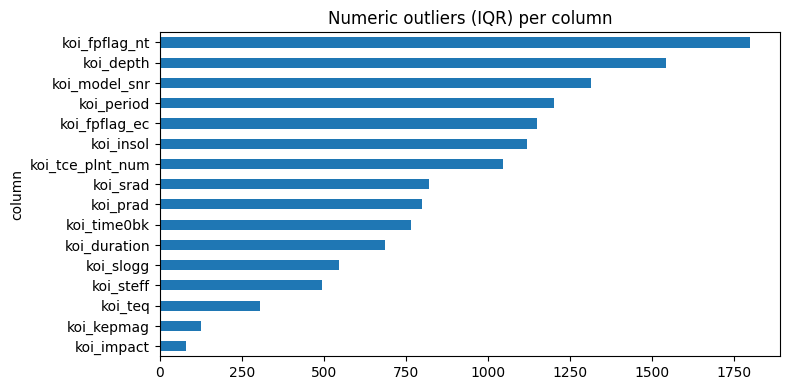

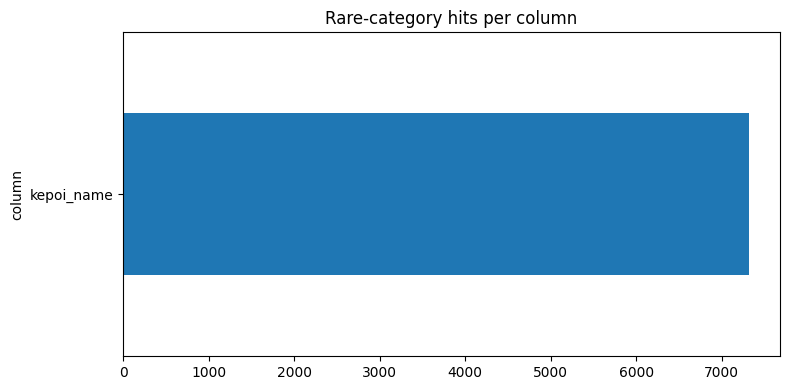

In [20]:
# Plot: numeric outlier counts by column 
plt.figure(figsize=(8, 4))
(outlier_report.query("rule=='IQR'")
 .groupby("column").size().sort_values(ascending=True)
 .plot(kind="barh"))
plt.title("Numeric outliers (IQR) per column")
plt.tight_layout()
plt.show()

# Plot: rare-category counts by column 
plt.figure(figsize=(8, 4))
(outlier_report.query("rule=='RARE_CATEGORY'")
 .groupby("column").size().sort_values(ascending=True)
 .plot(kind="barh"))
plt.title("Rare-category hits per column")
plt.tight_layout()
plt.show()


## Build Two Versions (no‑treatment vs cleaned)

In [21]:
# No-treatment copy 
df_no_treat = df.copy()

# Cleaned (winsorize numeric + merge rare categories → 'OTHER') 
df_clean = df.copy()

# winsorize numeric (leave binaries/IDs untouched)
for c, (lo, hi) in iqr_map.items():
    df_clean[c] = df_clean[c].clip(lower=lo, upper=hi)

# merge rare categories
for c, rare_vals in rare_map.items():
    df_clean[c] = df_clean[c].where(~df_clean[c].isin(rare_vals), other="OTHER")
    # optional: tighter dtype
    try:
        df_clean[c] = df_clean[c].astype("category")
    except Exception:
        pass

print("Shapes no_treat:", df_no_treat.shape, "| cleaned:", df_clean.shape)


Shapes no_treat: (7316, 25) | cleaned: (7316, 25)


## Zero variance check

In [22]:
def zero_variance_columns(df):
    return [c for c in df.columns if df[c].nunique(dropna=False) <= 1]

zero_var_no_treat = zero_variance_columns(df_no_treat)
zero_var_clean    = zero_variance_columns(df_clean)

print("Zero variance columns (no-treatment):", zero_var_no_treat)
print("Zero variance columns (cleaned):", zero_var_clean)

Zero variance columns (no-treatment): []
Zero variance columns (cleaned): ['kepoi_name', 'koi_fpflag_nt', 'koi_fpflag_ec', 'koi_tce_plnt_num']


In [23]:
# Drop zero-variance columns before scaling 
if zero_var_no_treat:
    df_no_treat.drop(columns=zero_var_no_treat, inplace=True)
if zero_var_clean:
    df_clean.drop(columns=zero_var_clean, inplace=True)

print("After dropping zero variance cols:")
print(" no_treat shape:", df_no_treat.shape)
print(" cleaned shape:", df_clean.shape)


After dropping zero variance cols:
 no_treat shape: (7316, 25)
 cleaned shape: (7316, 21)


# Label creation & alignment

In [24]:
#  Label creation & alignment 
import numpy as np
import pandas as pd

#  Config
KEY_COL   = "rowid"
SRC_COL   = "koi_disposition"
LABEL_COL = "label"
LABEL_MAP = {"CONFIRMED": 1, "FALSE POSITIVE": 0}

# Ensure a unique key exists in ALL dataframes 
for _df_name in ["df_main", "df_clean", "df_no_treat"]:
    assert _df_name in globals(), f"{_df_name} is not defined"
    _df = globals()[_df_name]
    if KEY_COL not in _df.columns:
        # create a stable rowid if missing
        _df = _df.copy()
        _df[KEY_COL] = np.arange(len(_df), dtype=np.int64)
        globals()[_df_name] = _df  # write back

# Create label on df_main and keep only relevant rows
assert SRC_COL in df_main.columns, f"Missing column: {SRC_COL}"
df_main_f = df_main.copy()

mask_keep = df_main_f[SRC_COL].isin(LABEL_MAP)
dropped = int((~mask_keep).sum())
if dropped:
    print(f"Removing {dropped} rows not in {list(LABEL_MAP.keys())}:",
          df_main_f.loc[~mask_keep, SRC_COL].value_counts().to_dict())

df_main_f = df_main_f.loc[mask_keep].reset_index(drop=True)
df_main_f[LABEL_COL] = df_main_f[SRC_COL].map(LABEL_MAP).astype("int8")
df_main_f.drop(columns=[SRC_COL], inplace=True)

print("df_main filtered:", df_main_f.shape,
      "| label dist:", df_main_f[LABEL_COL].value_counts().to_dict())

# Align CLEANED and NO_TREAT to df_main_f and bring label
def align_and_add_label(df_any: pd.DataFrame, main_df: pd.DataFrame, key: str) -> pd.DataFrame:
    assert key in df_any.columns,  f"{key} not in df_any"
    assert key in main_df.columns, f"{key} not in main_df"
    out = df_any.merge(main_df[[key, LABEL_COL]], on=key, how="inner")
    return out

clean_aligned = align_and_add_label(df_clean.copy(),    df_main_f, KEY_COL)
orig_aligned  = align_and_add_label(df_no_treat.copy(), df_main_f, KEY_COL)

print("CLEANED aligned:", clean_aligned.shape, "| has label?", LABEL_COL in clean_aligned.columns)
print("NO_TREAT aligned:", orig_aligned.shape,  "| has label?", LABEL_COL in orig_aligned.columns)


df_main filtered: (7316, 25) | label dist: {0: 5023, 1: 2293}
CLEANED aligned: (7316, 22) | has label? True
NO_TREAT aligned: (7316, 26) | has label? True


# Normalize 


(keep all columns; scale only proper numeric) & Save 2 files (We won't use them in the model)

In [25]:
from sklearn.preprocessing import StandardScaler

# Normalize (proper numeric only) & Save 2 files
def is_true_binary(series: pd.Series) -> bool:
    u = pd.to_numeric(series, errors="coerce").dropna().unique()
    return len(u) <= 2 and set(u).issubset({0, 1})

def choose_columns_to_scale(df: pd.DataFrame,
                            id_cols=(), bin_cols=(), cat_cols=(),
                            label_col: str = "label",
                            prop_low_var_std: float = 0.05):
    numeric = list(df.select_dtypes(include=[np.number]).columns)
    protected = set(id_cols) | set(bin_cols) | set(cat_cols) | {label_col}
    candidates = [c for c in numeric if c not in protected]

    # auto-detect true binary
    auto_bin = [c for c in candidates if is_true_binary(df[c])]

    # proportions already in [0,1] with tiny variance → skip
    prop_like = []
    for c in candidates:
        if c in auto_bin:
            continue
        col = pd.to_numeric(df[c], errors="coerce").dropna()
        if len(col):
            mn, mx, sd = col.min(), col.max(), col.std()
            if (mn >= -1e-9) and (mx <= 1 + 1e-9) and (sd < prop_low_var_std):
                prop_like.append(c)

    skip = set(id_cols) | set(bin_cols) | set(cat_cols) | set(auto_bin) | set(prop_like) | {label_col}
    to_scale = [c for c in numeric if c not in skip]
    return to_scale

ID_COLS  = [c for c in [KEY_COL, "rowid", "kepid"] if c in clean_aligned.columns]
BIN_COLS = []  
CAT_COLS = []   

cols_to_scale_clean = choose_columns_to_scale(clean_aligned, id_cols=ID_COLS, bin_cols=BIN_COLS, cat_cols=CAT_COLS, label_col=LABEL_COL)
cols_to_scale_orig  = choose_columns_to_scale(orig_aligned,  id_cols=ID_COLS, bin_cols=BIN_COLS, cat_cols=CAT_COLS, label_col=LABEL_COL)

print("CLEANED to scale:", len(cols_to_scale_clean), "columns")
print("NO_TREAT to scale:", len(cols_to_scale_orig),  "columns")

def scale_copy(df: pd.DataFrame, cols_to_scale, scaler=None):
    x = df.copy()
    if cols_to_scale:
        sc = scaler or StandardScaler()
        if scaler is None:
            x[cols_to_scale] = sc.fit_transform(x[cols_to_scale])
        else:
            x[cols_to_scale] = sc.transform(x[cols_to_scale])
        return x, sc
    return x, None

clean_scaled, clean_scaler = scale_copy(clean_aligned, cols_to_scale_clean)
orig_scaled,  orig_scaler  = scale_copy(orig_aligned,  cols_to_scale_orig)

# Final checks & save
assert LABEL_COL in clean_scaled.columns, "Label missing from CLEANED!"
assert LABEL_COL in orig_scaled.columns,  "Label missing from NO_TREAT!"

clean_scaled_path = "data/kepler_cleaned_scaled.csv"
orig_scaled_path  = "data/kepler_with_outliers_scaled.csv"

clean_scaled.to_csv(clean_scaled_path, index=False)
orig_scaled.to_csv(orig_scaled_path,  index=False)

print(f"Saved CLEANED  {clean_scaled_path} | shape: {clean_scaled.shape}")
print(f"Saved NO_TREAT {orig_scaled_path}  | shape: {orig_scaled.shape}")


CLEANED to scale: 15 columns
NO_TREAT to scale: 16 columns
Saved CLEANED  data/kepler_cleaned_scaled.csv | shape: (7316, 22)
Saved NO_TREAT data/kepler_with_outliers_scaled.csv  | shape: (7316, 26)


# Modeling Setup

In [26]:
df_main = clean_aligned.copy()  
print("shape:", df_main.shape)

# Define metadata columns (excluded from modeling)
meta_cols = [
    "kepid", "kepoi_name", "kepler_name", "rowid", "ra", "dec",
    "koi_pdisposition", "koi_tce_plnt_num", "koi_tce_delivname", "koi_disposition"
]

# Build model dataframe (features + label) and the full dataframe (with metadata)
assert "label" in df_main.columns, "Missing `label` column. Create it before this step."
model_cols = [c for c in df_main.columns if c not in meta_cols]
df_model = df_main[model_cols].copy()
df_with_metadata = df_main.copy()

# Save both datasets
df_model.to_csv("data/kepler_model_ready.csv", index=False)
df_with_metadata.to_csv("data/kepler_with_metadata.csv", index=False)

# Summary
print("Files saved")
print(f"kepler_model_ready.csv     {df_model.shape[0]} rows × {df_model.shape[1]} cols")
print(f"kepler_with_metadata.csv   {df_with_metadata.shape[0]} rows × {df_with_metadata.shape[1]} cols")
print("Features in model:", sorted(df_model.columns.tolist()))


shape: (7316, 22)
Files saved
kepler_model_ready.csv     7316 rows × 16 cols
kepler_with_metadata.csv   7316 rows × 22 cols
Features in model: ['koi_depth', 'koi_duration', 'koi_fpflag_co', 'koi_fpflag_ss', 'koi_impact', 'koi_insol', 'koi_kepmag', 'koi_model_snr', 'koi_period', 'koi_prad', 'koi_slogg', 'koi_srad', 'koi_steff', 'koi_teq', 'koi_time0bk', 'label']


## Data load, split & scale

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Load data, split, scale 
df = pd.read_csv("data/kepler_model_ready.csv")
X = df.drop(columns=["label"]).astype("float32").values
y = df["label"].astype("float32").values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# class weights
classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): w for c, w in zip(classes, cw)}
class_weight

{0: np.float64(0.7282229965156795), 1: np.float64(1.5954198473282444)}

## Functions for model evaluation

In [28]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, brier_score_loss, classification_report


np.random.seed(42)
tf.random.set_seed(42)


def plot_curves(history, title_prefix=""):
    """Plot train vs. val curves for loss and AUC."""
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    plt.figure()
    plt.plot(epochs, h["loss"], label="train_loss")
    if "val_loss" in h: plt.plot(epochs, h["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Binary cross-entropy"); plt.title(f"{title_prefix} Loss Curves"); plt.legend()
    plt.savefig(f"figures/MLP/{title_prefix}_loss_curves.pdf")
    plt.show()

    if "auc" in h:
        plt.figure()
        plt.plot(epochs, h["auc"], label="train_auc")
        if "val_auc" in h: plt.plot(epochs, h["val_auc"], label="val_auc")
        plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.title(f"{title_prefix} AUC Curves"); plt.legend()
        plt.savefig(f"figures/MLP/{title_prefix}_auc_curves.pdf")
        plt.show()

def evaluate_on_sets(model, X_train, y_train, X_test, y_test, name="Model", train_time=None):


    total_t0 = time.perf_counter()

    # Inference time (both sets)
    t0_pred = time.perf_counter()
    if hasattr(model, "predict_proba"):
        p_tr = model.predict_proba(X_train)[:, 1]
        p_te = model.predict_proba(X_test)[:, 1]
    else:
        p_tr = model.predict(X_train, verbose=0).ravel()
        p_te = model.predict(X_test,  verbose=0).ravel()
    eval_time = time.perf_counter() - t0_pred

    # Inference time (test only)
    t1 = time.perf_counter()
    _ = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_test, verbose=0)
    infer_time_test = time.perf_counter() - t1

    total_time = time.perf_counter() - total_t0

    pred_tr = (p_tr >= 0.5).astype(int)
    pred_te = (p_te >= 0.5).astype(int)

    acc_tr = accuracy_score(y_train, pred_tr); acc_te = accuracy_score(y_test, pred_te)
    auc_tr = roc_auc_score(y_train, p_tr);     auc_te = roc_auc_score(y_test,  p_te)
    ll_tr  = log_loss(y_train, p_tr);          ll_te  = log_loss(y_test,  p_te)
    brier  = brier_score_loss(y_test, p_te)

    if train_time is not None:
        print(f"[{name}] Timings -> total: {total_time:.2f}s | train: {train_time:.2f}s | eval: {eval_time:.2f}s")
    else:
        print(f"[{name}] Timings -> total: {total_time:.2f}s | eval: {eval_time:.2f}s")
    print(f"[{name}] inference time (test only): {infer_time_test:.3f}s")
    print(f"Train -> Acc: {acc_tr:.4f} | AUC: {auc_tr:.4f} | LogLoss: {ll_tr:.4f}")
    print(f"Test  -> Acc: {acc_te:.4f} | AUC: {auc_te:.4f} | LogLoss: {ll_te:.4f} | Brier: {brier:.4f}")
    print(f"Gaps  -> Acc: {acc_tr - acc_te:+.4f} | AUC: {auc_tr - auc_te:+.4f}")
    print("\nClassification report (test):\n", classification_report(y_test, pred_te, digits=4))

    return {
        "name": name, "acc_train": acc_tr, "acc_test": acc_te,
        "auc_train": auc_tr, "auc_test": auc_te,
        "ll_train": ll_tr, "ll_test": ll_te, "brier_test": brier,
        "train_time_sec": train_time,
        "eval_time_sec": eval_time,
        "total_time_sec": total_time,
        "infer_time_test_sec": infer_time_test
    }


def ece_mce(y_true, p_pred, n_bins=10, use_quantiles=True):
    y= np.asarray(y_true).ravel()
    p = np.asarray(p_pred).ravel()
    if use_quantiles:
        edges = np.unique(np.quantile(p, np.linspace(0, 1, n_bins + 1)))
        if edges.size < n_bins + 1:
            edges = np.linspace(0, 1, n_bins + 1)
    else:
        edges = np.linspace(0, 1, n_bins + 1)
    idx = np.clip(np.digitize(p, edges) - 1, 0, edges.size - 2)
    N = y.size
    ece = 0.0
    mce = 0.0
    for b in range(edges.size - 1):
        m = (idx == b)
        if not m.any():
            continue
        conf = p[m].mean()
        acc = y[m].mean()
        gap = abs(acc - conf)
        ece += gap * (m.sum() / N)
        mce = max(mce, gap)
    return float(ece), float(mce)


# MLP

## Baseline MLP (shows overfitting)

Visible GPUs: []
Epoch 1/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8684 - auc: 0.9301 - loss: 0.3331 - val_accuracy: 0.9197 - val_auc: 0.9679 - val_loss: 0.2158
Epoch 2/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.9212 - auc: 0.9705 - loss: 0.2050 - val_accuracy: 0.9342 - val_auc: 0.9775 - val_loss: 0.1743
Epoch 3/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.9336 - auc: 0.9780 - loss: 0.1760 - val_accuracy: 0.9462 - val_auc: 0.9822 - val_loss: 0.1549
Epoch 4/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.9408 - auc: 0.9817 - loss: 0.1589 - val_accuracy: 0.9522 - val_auc: 0.9843 - val_loss: 0.1435
Epoch 5/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.9427 - auc: 0.9841 - loss: 0.1474 - val_accuracy: 0.9530 - val_auc: 0.9856 - val_loss: 0.1362
Epoch 6/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.9468 - auc: 0.9860 - loss: 0.1387 - val_accuracy: 0.9590 - val_auc: 0.9865 - val_loss: 0.1315
Epoch 7/80
14

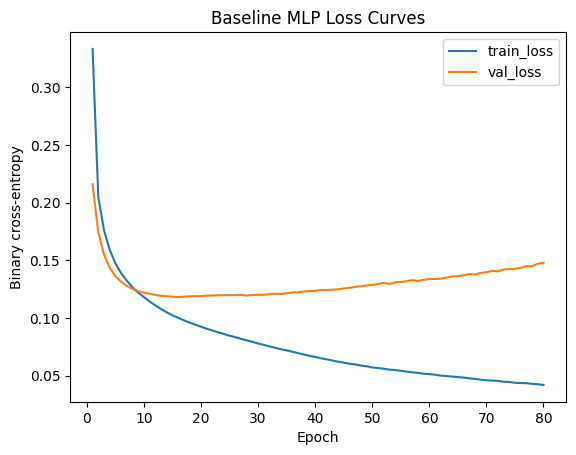

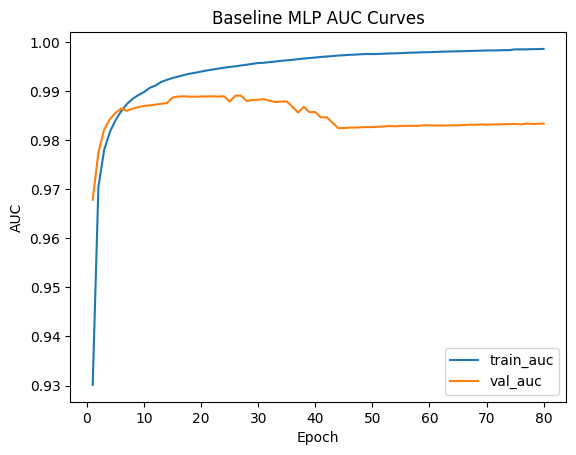

[Baseline MLP] Timings -> total: 0.18s | eval: 0.14s
[Baseline MLP] inference time (test only): 0.036s
Train -> Acc: 0.9841 | AUC: 0.9973 | LogLoss: 0.0583
Test  -> Acc: 0.9583 | AUC: 0.9848 | LogLoss: 0.1894 | Brier: 0.0365
Gaps  -> Acc: +0.0258 | AUC: +0.0125

Classification report (test):
               precision    recall  f1-score   support

         0.0     0.9683    0.9711    0.9697      1005
         1.0     0.9364    0.9303    0.9333       459

    accuracy                         0.9583      1464
   macro avg     0.9523    0.9507    0.9515      1464
weighted avg     0.9583    0.9583    0.9583      1464



In [29]:
# Baseline MLP: no dropout, no L2, no early stopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

print("Visible GPUs:", tf.config.list_physical_devices('GPU')) ## empty line for GPU visibility means we use CPU (that what we want)

baseline = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_s.shape[1],)),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

baseline.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

t0 = time.perf_counter()
hist_base = baseline.fit(
    X_train_s, y_train,
    validation_split=0.20,   
    epochs=80,               
    batch_size=32,
    verbose=1
)
t_train = time.perf_counter() - t0
print(f"[Baseline MLP] training time: {t_train:.2f}s | epochs: {len(hist_base.history['loss'])}")

plot_curves(hist_base, title_prefix="Baseline MLP")
mlp_res_base = evaluate_on_sets(baseline, X_train_s, y_train, X_test_s, y_test, name="Baseline MLP")


## Regularized MLP (fix overfitting)

Epoch 1/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8481 - auc: 0.9239 - loss: 0.3773 - val_accuracy: 0.9112 - val_auc: 0.9677 - val_loss: 0.2431 - learning_rate: 0.0010
Epoch 2/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.9030 - auc: 0.9618 - loss: 0.2475 - val_accuracy: 0.9240 - val_auc: 0.9749 - val_loss: 0.2132 - learning_rate: 0.0010
Epoch 3/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.9118 - auc: 0.9697 - loss: 0.2175 - val_accuracy: 0.9291 - val_auc: 0.9791 - val_loss: 0.1893 - learning_rate: 0.0010
Epoch 4/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.9190 - auc: 0.9761 - loss: 0.1970 - val_accuracy: 0.9317 - val_auc: 0.9813 - val_loss: 0.1786 - learning_rate: 0.0010
Epoch 5/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.9242 - auc: 0.9776 - loss: 0.1906 - val_accuracy: 0.9377 - val_auc: 0.9837 - val_loss: 0.1662 - learning_rate: 0.0010
Epoch 6/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.9284

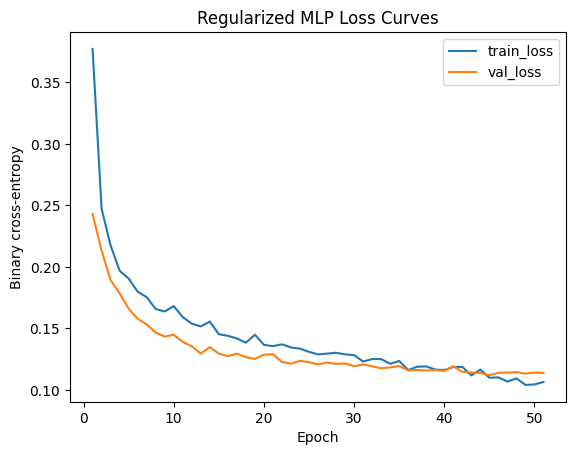

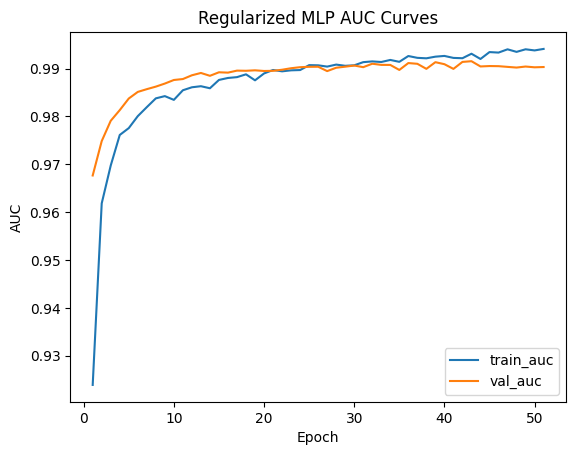

[Regularized MLP] Timings -> total: 0.17s | eval: 0.13s
[Regularized MLP] inference time (test only): 0.037s
Train -> Acc: 0.9651 | AUC: 0.9948 | LogLoss: 0.0907
Test  -> Acc: 0.9529 | AUC: 0.9872 | LogLoss: 0.1373 | Brier: 0.0353
Gaps  -> Acc: +0.0123 | AUC: +0.0076

Classification report (test):
               precision    recall  f1-score   support

         0.0     0.9756    0.9552    0.9653      1005
         1.0     0.9062    0.9477    0.9265       459

    accuracy                         0.9529      1464
   macro avg     0.9409    0.9515    0.9459      1464
weighted avg     0.9539    0.9529    0.9531      1464



In [30]:
# --- Regularized MLP: dropout + L2 + early stopping + LR scheduling + class weights ---
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

reg_mlp = Sequential([
    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4), input_shape=(X_train_s.shape[1],)),
    Dropout(0.2),
    Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    Dense(1, activation="sigmoid")
])

reg_mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

callbacks = [
    EarlyStopping(monitor="val_auc", mode="max", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
]

t0 = time.perf_counter()
hist_reg = reg_mlp.fit(
    X_train_s, y_train,
    validation_split=0.20,
    epochs=80,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight,  
    verbose=1
)
t_train = time.perf_counter() - t0
print(f"[Regularized MLP] training time: {t_train:.2f}s | epochs: {len(hist_reg.history['loss'])}")

plot_curves(hist_reg, title_prefix="Regularized MLP")
mlp_res_reg = evaluate_on_sets(reg_mlp, X_train_s, y_train, X_test_s, y_test, name="Regularized MLP")


## Hyperparameter Tuning (KerasTuner)

Reloading Tuner from tuner_logs/mlp_kepler/tuner0.json
[Tuner] total search time: 0.00s
Best hyperparameters:
 {'units1': 256, 'l2_1': 0.0001, 'dropout1': 0.4, 'units2': 32, 'l2_2': 0.0, 'dropout2': 0.4, 'lr': 0.001}
Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8432 - auc: 0.9253 - loss: 0.3565 - val_accuracy: 0.9240 - val_auc: 0.9698 - val_loss: 0.2209
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.9120 - auc: 0.9654 - loss: 0.2304 - val_accuracy: 0.9266 - val_auc: 0.9782 - val_loss: 0.1898
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.9201 - auc: 0.9701 - loss: 0.2117 - val_accuracy: 0.9419 - val_auc: 0.9825 - val_loss: 0.1603
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.9261 - auc: 0.9748 - loss: 0.1964 - val_accuracy: 0.9471 - val_auc: 0.9859 - val_loss: 0.1492
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.9333 - auc: 0.9785 - loss: 0.1786 - val_accuracy: 0.9496 - val_a

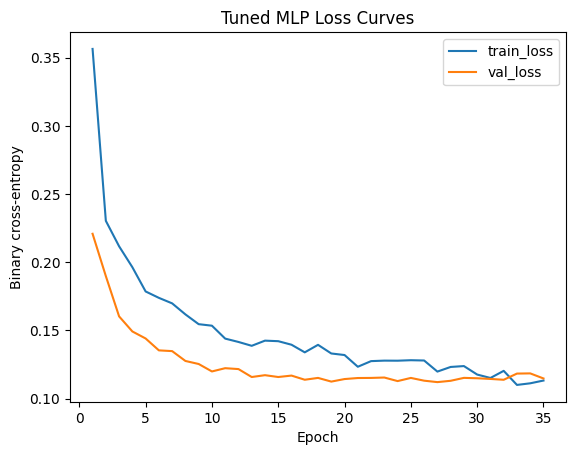

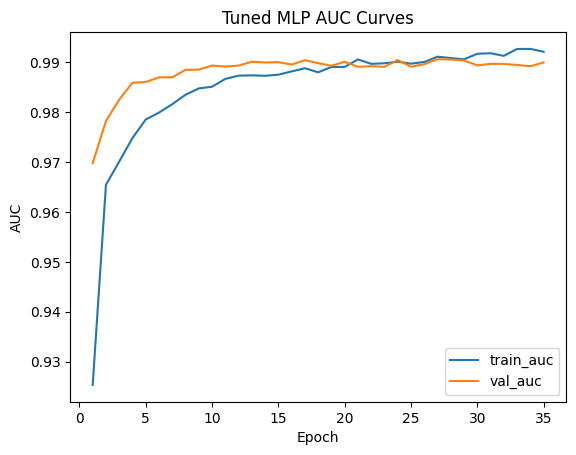

[Tuned MLP] Timings -> total: 0.17s | eval: 0.14s
[Tuned MLP] inference time (test only): 0.035s
Train -> Acc: 0.9639 | AUC: 0.9939 | LogLoss: 0.0965
Test  -> Acc: 0.9508 | AUC: 0.9860 | LogLoss: 0.1452 | Brier: 0.0363
Gaps  -> Acc: +0.0131 | AUC: +0.0080

Classification report (test):
               precision    recall  f1-score   support

         0.0     0.9679    0.9602    0.9640      1005
         1.0     0.9143    0.9303    0.9222       459

    accuracy                         0.9508      1464
   macro avg     0.9411    0.9452    0.9431      1464
weighted avg     0.9511    0.9508    0.9509      1464



In [31]:
# Hyperparameter tuning with KerasTuner (optimize val_auc)
import keras_tuner as kt

def build_model(hp: kt.HyperParameters):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train_s.shape[1],)))

    units1 = hp.Int('units1', 64, 256, step=32)
    model.add(tf.keras.layers.Dense(units1, activation='relu',
                                    kernel_regularizer=regularizers.l2(hp.Choice('l2_1', [0.0, 1e-4, 5e-4]))))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout1', 0.0, 0.5, step=0.1)))

    units2 = hp.Int('units2', 32, 128, step=16)
    model.add(tf.keras.layers.Dense(units2, activation='relu',
                                    kernel_regularizer=regularizers.l2(hp.Choice('l2_2', [0.0, 1e-4, 5e-4]))))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout2', 0.0, 0.5, step=0.1)))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    lr = hp.Choice('lr', [1e-2, 5e-3, 1e-3, 5e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=12, executions_per_trial=1,
    directory='tuner_logs', project_name='mlp_kepler'
)

early = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True)

t0 = time.perf_counter()
tuner.search(
    X_train_s, y_train,
    validation_split=0.20,
    epochs=60,
    batch_size=32,
    callbacks=[early],
    verbose=1,
    class_weight=class_weight
)
t_tune = time.perf_counter() - t0
print(f"[Tuner] total search time: {t_tune:.2f}s")

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:\n", best_hp.values)

mlp_best = tuner.hypermodel.build(best_hp)
hist_best = mlp_best.fit(
    X_train_s, y_train,
    validation_split=0.20,
    epochs=100,
    batch_size=32,
    callbacks=[early],
    verbose=1,
    class_weight=class_weight
)
best_epoch = 1 + int(np.argmax(hist_best.history["val_auc"]))
print(f"Best epoch (val_auc): {best_epoch} / {len(hist_best.history['val_auc'])}")

plot_curves(hist_best, title_prefix="Tuned MLP")
mlp_res_tuned = evaluate_on_sets(mlp_best, X_train_s, y_train, X_test_s, y_test, name="Tuned MLP")


In [32]:
p = mlp_best.predict(X_test_s, verbose=0).ravel()
y_true_test = np.asarray(y_test)

ap = average_precision_score(y_true_test, p)
ece, mce = ece_mce(y_true_test, p)  # uses your utility

print(f"AP (PR-AUC): {ap:.4f}")
print(f"Calibration -> ECE: {ece:.4f} | MCE: {mce:.4f}")

AP (PR-AUC): 0.9740
Calibration -> ECE: 0.0173 | MCE: 0.0513


## Summary table (compare the three)

In [33]:
# --- Summary comparison ---
summary = pd.DataFrame([mlp_res_base, mlp_res_reg, mlp_res_tuned])[
    ["name","acc_train","acc_test","auc_train","auc_test","ll_train","ll_test","brier_test"]
]
summary


,name,acc_train,acc_test,auc_train,auc_test,ll_train,ll_test,brier_test
0,Baseline MLP,0.984108,0.958333,0.997273,0.984785,0.058256,0.189394,0.036520
1,Regularized MLP,0.965140,0.952869,0.994823,0.987234,0.090680,0.137325,0.035277
2,Tuned MLP,0.963944,0.950820,0.993906,0.985955,0.096542,0.145206,0.036270


# RANDOM FOREST

## Baseline RF

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import roc_auc_score

# Baseline RF

print("\n[Baseline RF]")
print("Config:", {'n_estimators': 100, 'max_depth': None, 'oob_score': True, 'random_state': 42})

rf_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Train timing
t0 = time.perf_counter()
rf_base.fit(X_train, y_train)
train_time = time.perf_counter() - t0

# Unified evaluation (prints timings, metrics, gaps, and classification report)
rf_res_base = evaluate_on_sets(
    rf_base,
    X_train, y_train,
    X_test,  y_test,
    name="Baseline RF",
    train_time=train_time
)

# OOB metrics (extra, RF-specific)
oob_acc = rf_base.oob_score_
pos_idx = list(rf_base.classes_).index(1)      # ודא שהמחלקה החיובית היא 1
oob_auc = roc_auc_score(y_train, rf_base.oob_decision_function_[:, pos_idx])
print(f"OOB Acc: {oob_acc:.4f} | OOB AUC: {oob_auc:.4f}")

# pack for summary table
rf_res_base.update({
    "name": "RF Baseline",
    "trees": rf_base.n_estimators,
    "oob_acc": oob_acc,
    "oob_auc": oob_auc
})



[Baseline RF]
Config: {'n_estimators': 100, 'max_depth': None, 'oob_score': True, 'random_state': 42}
[Baseline RF] Timings -> total: 0.04s | train: 0.15s | eval: 0.03s
[Baseline RF] inference time (test only): 0.014s
Train -> Acc: 1.0000 | AUC: 1.0000 | LogLoss: 0.0262
Test  -> Acc: 0.9658 | AUC: 0.9908 | LogLoss: 0.1308 | Brier: 0.0291
Gaps  -> Acc: +0.0342 | AUC: +0.0092

Classification report (test):
               precision    recall  f1-score   support

         0.0     0.9659    0.9851    0.9754      1005
         1.0     0.9658    0.9237    0.9443       459

    accuracy                         0.9658      1464
   macro avg     0.9658    0.9544    0.9598      1464
weighted avg     0.9658    0.9658    0.9656      1464

OOB Acc: 0.9752 | OOB AUC: 0.9946


[Learning curve] train_sizes=5 | CV folds=5 | runtime: 3.181s | approx fits=25


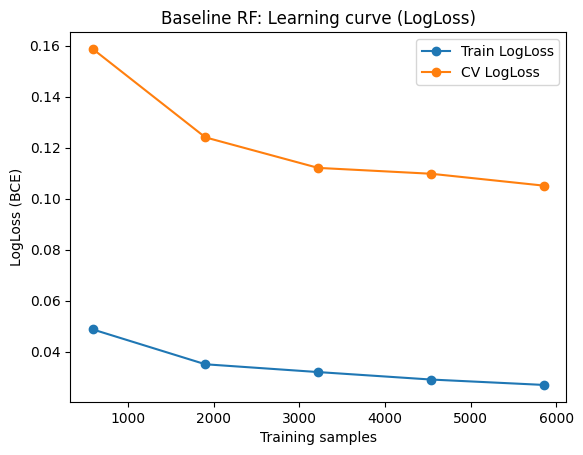

In [35]:
# Learning curve (train size) — classic overfitting view
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes = np.linspace(0.1, 1.0, 5)
t3 = time.perf_counter()
ts, tr_scores, cv_scores = learning_curve(
    RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1),
    X, y, train_sizes=train_sizes, cv=cv, scoring="neg_log_loss", n_jobs=-1, shuffle=True, random_state=42
)
lc_time = time.perf_counter() - t3
print(f"[Learning curve] train_sizes={len(train_sizes)} | CV folds=5 | runtime: {lc_time:.3f}s "
      f"| approx fits={len(train_sizes)*5}")

plt.figure()
plt.plot(ts, -tr_scores.mean(axis=1), marker="o", label="Train LogLoss")
plt.plot(ts, -cv_scores.mean(axis=1), marker="o", label="CV LogLoss")
plt.xlabel("Training samples"); plt.ylabel("LogLoss (BCE)")
plt.title("Baseline RF: Learning curve (LogLoss)")
plt.legend()
plt.savefig("figures/RF/baseline_rf_learning_curve.pdf")
plt.show()

[Trees sweep] steps=7 | total runtime: 0.488s


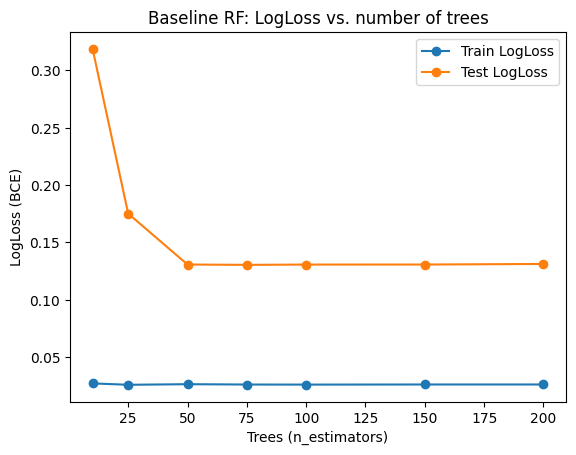

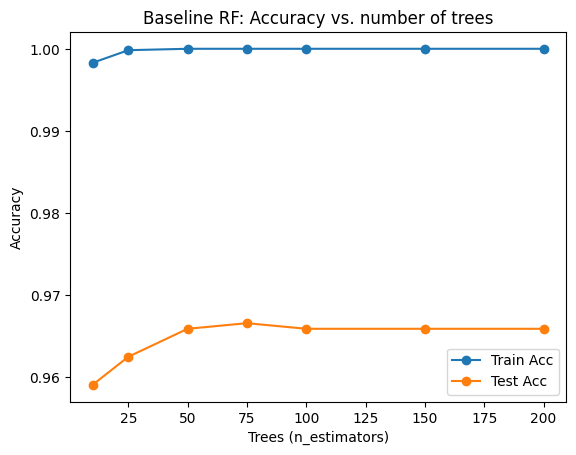

In [36]:
# Curves vs. number of trees (warm_start growth)
steps = [10, 25, 50, 75, 100, 150, 200]
rf_ws = RandomForestClassifier(
    n_estimators=0,  # will set below
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    warm_start=True
)

trees_list, tr_acc_list, te_acc_list, tr_ll_list, te_ll_list = [], [], [], [], []
t1 = time.perf_counter()
for n in steps:
    rf_ws.set_params(n_estimators=n)
    rf_ws.fit(X_train, y_train)  # adds trees incrementally
    p_tr = rf_ws.predict_proba(X_train)[:, 1]
    p_te = rf_ws.predict_proba(X_test)[:, 1]
    tr_acc_list.append(accuracy_score(y_train, (p_tr >= 0.5)))
    te_acc_list.append(accuracy_score(y_test,  (p_te >= 0.5)))
    tr_ll_list.append(log_loss(y_train, p_tr))
    te_ll_list.append(log_loss(y_test,  p_te))
    trees_list.append(n)
trees_time = time.perf_counter() - t1
print(f"[Trees sweep] steps={len(steps)} | total runtime: {trees_time:.3f}s")

plt.figure()
plt.plot(trees_list, tr_ll_list, marker="o", label="Train LogLoss")
plt.plot(trees_list, te_ll_list, marker="o", label="Test LogLoss")
plt.xlabel("Trees (n_estimators)"); plt.ylabel("LogLoss (BCE)")
plt.title("Baseline RF: LogLoss vs. number of trees")
plt.legend()
plt.savefig("figures/RF/baseline_rf_logloss_vs_trees.pdf")
plt.show()

plt.figure()
plt.plot(trees_list, tr_acc_list, marker="o", label="Train Acc")
plt.plot(trees_list, te_acc_list, marker="o", label="Test Acc")
plt.xlabel("Trees (n_estimators)"); plt.ylabel("Accuracy")
plt.title("Baseline RF: Accuracy vs. number of trees")
plt.legend()
plt.savefig("figures/RF/baseline_rf_acc_vs_trees.pdf")
plt.show()

[Depth sweep] depths tested=6 | runtime: 1.394s | trees per fit=200


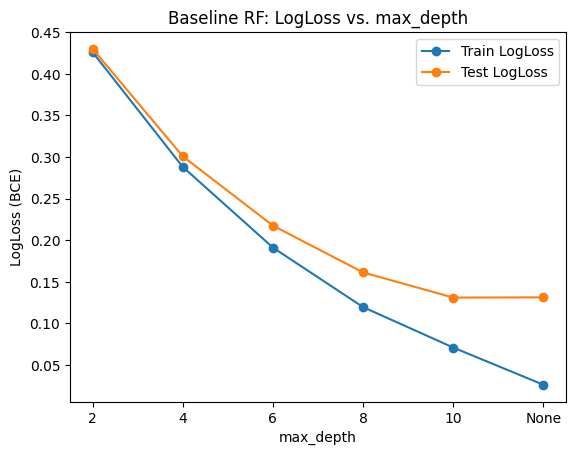

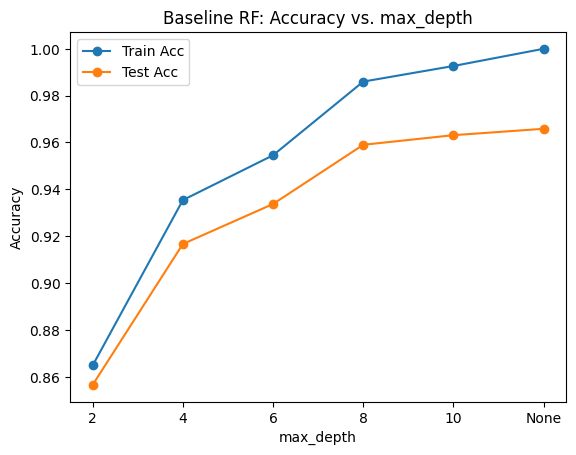

In [37]:

# Curves vs. model capacity (tree depth) — clearer overfitting signal
depths = [2, 4, 6, 8, 10, None]
tr_acc_d, te_acc_d, tr_ll_d, te_ll_d = [], [], [], []
t2 = time.perf_counter()
for d in depths:
    rf_d = RandomForestClassifier(
        n_estimators=200, max_depth=d, random_state=42, n_jobs=-1
    )
    rf_d.fit(X_train, y_train)
    p_tr = rf_d.predict_proba(X_train)[:, 1]
    p_te = rf_d.predict_proba(X_test)[:, 1]
    tr_acc_d.append(accuracy_score(y_train, (p_tr >= 0.5)))
    te_acc_d.append(accuracy_score(y_test,  (p_te >= 0.5)))
    tr_ll_d.append(log_loss(y_train, p_tr))
    te_ll_d.append(log_loss(y_test,  p_te))
depth_time = time.perf_counter() - t2
print(f"[Depth sweep] depths tested={len(depths)} | runtime: {depth_time:.3f}s | trees per fit=200")

x = [str(d) for d in depths]
plt.figure()
plt.plot(x, tr_ll_d, marker="o", label="Train LogLoss")
plt.plot(x, te_ll_d, marker="o", label="Test LogLoss")
plt.xlabel("max_depth"); plt.ylabel("LogLoss (BCE)")
plt.title("Baseline RF: LogLoss vs. max_depth")
plt.legend()
plt.savefig("figures/RF/baseline_rf_logloss_vs_depth.pdf")
plt.show()

plt.figure()
plt.plot(x, tr_acc_d, marker="o", label="Train Acc")
plt.plot(x, te_acc_d, marker="o", label="Test Acc")
plt.xlabel("max_depth"); plt.ylabel("Accuracy")
plt.title("Baseline RF: Accuracy vs. max_depth")
plt.legend()
plt.savefig("figures/RF/baseline_rf_acc_vs_depth.pdf")
plt.show()

## Regularized RF

In [38]:
# Regularized RF

print("\n[Regularized RF]")
print("Config:", {
    'n_estimators': 500, 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 20,
    'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced_subsample', 'oob_score': True
})

rf_reg = RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    min_samples_leaf=5,
    min_samples_split=20,
    max_features="sqrt",
    bootstrap=True,
    class_weight="balanced_subsample",
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Train timing
t0 = time.perf_counter()
rf_reg.fit(X_train, y_train)
train_time = time.perf_counter() - t0

# Unified evaluation (prints timings, metrics, gaps, and classification report)
rf_res_reg = evaluate_on_sets(
    rf_reg,
    X_train, y_train,
    X_test,  y_test,
    name="RF Regularized",
    train_time=train_time
)

# OOB metrics (RF-specific)
oob_acc = rf_reg.oob_score_
pos_idx = list(rf_reg.classes_).index(1) 
oob_auc = roc_auc_score(y_train, rf_reg.oob_decision_function_[:, pos_idx])
print(f"OOB Acc: {oob_acc:.4f} | OOB AUC: {oob_auc:.4f}")

# Pack for summary table
rf_res_reg.update({
    "trees": rf_reg.n_estimators,
    "oob_acc": oob_acc,
    "oob_auc": oob_auc
})



[Regularized RF]
Config: {'n_estimators': 500, 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 20, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced_subsample', 'oob_score': True}
[RF Regularized] Timings -> total: 0.15s | train: 0.75s | eval: 0.10s
[RF Regularized] inference time (test only): 0.050s
Train -> Acc: 0.9684 | AUC: 0.9962 | LogLoss: 0.1328
Test  -> Acc: 0.9495 | AUC: 0.9875 | LogLoss: 0.1639 | Brier: 0.0411
Gaps  -> Acc: +0.0189 | AUC: +0.0087

Classification report (test):
               precision    recall  f1-score   support

         0.0     0.9707    0.9552    0.9629      1005
         1.0     0.9053    0.9368    0.9208       459

    accuracy                         0.9495      1464
   macro avg     0.9380    0.9460    0.9418      1464
weighted avg     0.9502    0.9495    0.9497      1464

OOB Acc: 0.9586 | OOB AUC: 0.9922


[Depth sweep (regularized)] depths tested=5 | runtime: 3.645s | trees per fit=500


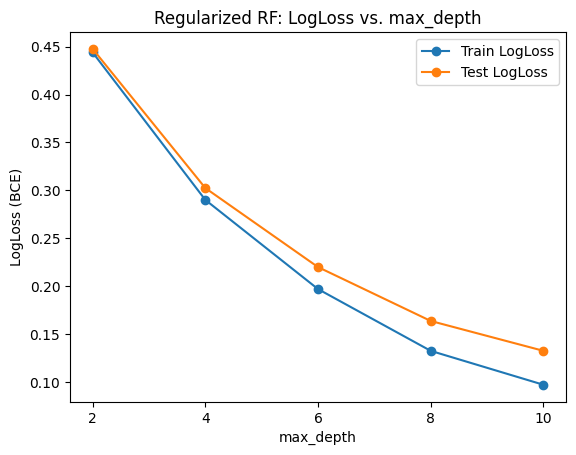

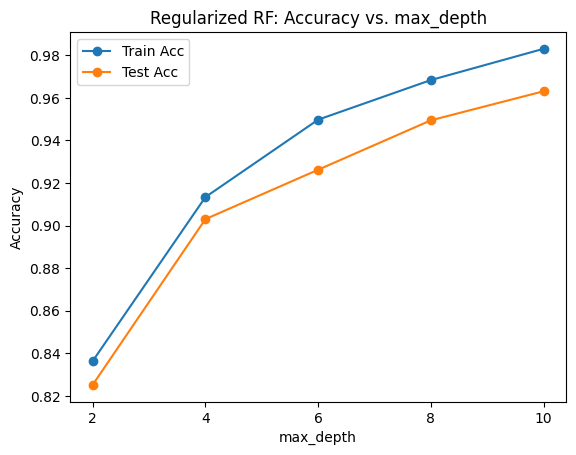

In [39]:

# Same diagnostics vs. depth (should show smaller gaps now)
depths = [2, 4, 6, 8, 10]
tr_ll_d, te_ll_d, tr_acc_d, te_acc_d = [], [], [], []
t1 = time.perf_counter()
for d in depths:
    rf_d = RandomForestClassifier(
        n_estimators=500, max_depth=d,
        min_samples_leaf=5, min_samples_split=20,
        max_features="sqrt", bootstrap=True, class_weight="balanced_subsample",
        random_state=42, n_jobs=-1
    )
    rf_d.fit(X_train, y_train)
    p_tr = rf_d.predict_proba(X_train)[:, 1]; p_te = rf_d.predict_proba(X_test)[:, 1]
    tr_ll_d.append(log_loss(y_train, p_tr));  te_ll_d.append(log_loss(y_test, p_te))
    tr_acc_d.append(accuracy_score(y_train, (p_tr >= 0.5)))
    te_acc_d.append(accuracy_score(y_test,  (p_te >= 0.5)))
depth_time = time.perf_counter() - t1
print(f"[Depth sweep (regularized)] depths tested={len(depths)} | runtime: {depth_time:.3f}s | trees per fit=500")

x = [str(d) for d in depths]


plt.figure()
plt.plot(x, tr_ll_d, marker="o", label="Train LogLoss")
plt.plot(x, te_ll_d, marker="o", label="Test LogLoss")
plt.xlabel("max_depth"); plt.ylabel("LogLoss (BCE)")
plt.title("Regularized RF: LogLoss vs. max_depth")
plt.legend()
plt.savefig("figures/RF/regularized_rf_logloss_vs_depth.pdf")
plt.show()

plt.figure()
plt.plot(x, tr_acc_d, marker="o", label="Train Acc")
plt.plot(x, te_acc_d, marker="o", label="Test Acc")
plt.xlabel("max_depth"); plt.ylabel("Accuracy")
plt.title("Regularized RF: Accuracy vs. max_depth")
plt.legend()
plt.savefig("figures/RF/regularized_rf_acc_vs_depth.pdf")
plt.show()

## Hyperparameter Tuning (RandomizedSearchCV)

In [40]:
# Config
RANDOM_STATE = 42
N_ITER = 40
N_ESTIMATORS_SEARCH = 300   # Trees during search
N_ESTIMATORS_FINAL  = 800
PARAM_SPACE = {
    "max_depth":         [None, 6, 8, 10],
    "min_samples_split": [2, 10, 20, 40],
    "min_samples_leaf":  [1, 3, 5, 10],
    "max_features":      ["sqrt", "log2", 0.5, None],
    "class_weight":      [None, "balanced_subsample"],
    "bootstrap":         [True],  # OOB requires bootstrap
}

# RNG for reproducibility
rng = np.random.default_rng(RANDOM_STATE)

# Function to sample random parameters
def sample_params(space):
    return {k: rng.choice(v) for k, v in space.items()}

# Search loop
results = []  # Store all runs
best_params, best_oob_auc, best_oob_ll = None, -np.inf, np.inf

t0 = time.perf_counter()
for i in range(N_ITER):
    params = sample_params(PARAM_SPACE)
    
    # Build RF model with sampled parameters
    rf = RandomForestClassifier(
        n_estimators=N_ESTIMATORS_SEARCH,
        oob_score=True,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        **params
    )
    rf.fit(X_train, y_train)
    
    # Get OOB predicted probabilities
    oob_proba = rf.oob_decision_function_[:, 1]
    oob_auc = roc_auc_score(y_train, oob_proba)
    oob_ll = log_loss(y_train, oob_proba)
    
    # Save results for later analysis
    results.append({**params, "oob_auc": oob_auc, "oob_logloss": oob_ll})
    
    # Track the best parameters
    if (oob_auc > best_oob_auc) or (np.isclose(oob_auc, best_oob_auc) and oob_ll < best_oob_ll):
        best_oob_auc, best_oob_ll = oob_auc, oob_ll
        best_params = params

t_search = time.perf_counter() - t0

# Convert to DataFrame
df_results = pd.DataFrame(results)

print(f"[OOB Random Search] combos tried={N_ITER} | runtime={t_search:.2f}s")
print(f"Best (by OOB AUC): AUC={best_oob_auc:.4f} | OOB LogLoss={best_oob_ll:.4f}")
print("Best params:", best_params)

# Save best params for later use
pd.Series(best_params).to_json("models/best_rf_params.json")
print("Best parameters saved to best_rf_params.json")


[OOB Random Search] combos tried=40 | runtime=18.85s
Best (by OOB AUC): AUC=0.9948 | OOB LogLoss=0.0976
Best params: {'max_depth': None, 'min_samples_split': np.int64(10), 'min_samples_leaf': np.int64(1), 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'bootstrap': np.True_}
Best parameters saved to best_rf_params.json


In [41]:
# Final RF refit (OOB-tuned) using the shared evaluate_on_sets 
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

assert best_params is not None, "best_params is None — did the OOB search run?"

# Merge final config (right-hand wins)
final_cfg = {
    **best_params,
    "n_estimators": N_ESTIMATORS_FINAL,
    "oob_score": True,
    "n_jobs": -1,
    "random_state": RANDOM_STATE,
}

print("\n[Final RF refit]")
print("Config:", final_cfg)

# Train + timing
rf_best = RandomForestClassifier(**final_cfg)
t0 = time.perf_counter()
rf_best.fit(X_train, y_train)
train_time = time.perf_counter() - t0

# Unified evaluation (prints timings, metrics, gaps, classification report)
rf_res_tuned = evaluate_on_sets(
    rf_best,
    X_train, y_train,
    X_test,  y_test,
    name="RF Final (OOB-tuned)",
    train_time=train_time
)

# OOB metrics (extra, RF-specific)
pos_idx = list(rf_best.classes_).index(1)   
oob_acc_final = rf_best.oob_score_
oob_auc_final = roc_auc_score(y_train, rf_best.oob_decision_function_[:, pos_idx])
print(f"OOB Acc: {oob_acc_final:.4f} | OOB AUC: {oob_auc_final:.4f}")

# Pack for summary table
rf_res_tuned.update({
    "trees": final_cfg["n_estimators"],
    "oob_acc": oob_acc_final,
    "oob_auc": oob_auc_final,
})



[Final RF refit]
Config: {'max_depth': None, 'min_samples_split': np.int64(10), 'min_samples_leaf': np.int64(1), 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'bootstrap': np.True_, 'n_estimators': 800, 'oob_score': True, 'n_jobs': -1, 'random_state': 42}
[RF Final (OOB-tuned)] Timings -> total: 0.23s | train: 1.23s | eval: 0.16s
[RF Final (OOB-tuned)] inference time (test only): 0.075s
Train -> Acc: 0.9935 | AUC: 0.9998 | LogLoss: 0.0461
Test  -> Acc: 0.9645 | AUC: 0.9906 | LogLoss: 0.1098 | Brier: 0.0278
Gaps  -> Acc: +0.0290 | AUC: +0.0092

Classification report (test):
               precision    recall  f1-score   support

         0.0     0.9649    0.9841    0.9744      1005
         1.0     0.9636    0.9216    0.9421       459

    accuracy                         0.9645      1464
   macro avg     0.9642    0.9528    0.9582      1464
weighted avg     0.9645    0.9645    0.9643      1464

OOB Acc: 0.9754 | OOB AUC: 0.9951


In [42]:
p_te = rf_best.predict_proba(X_test)[:, pos_idx]
ap = average_precision_score(y_test, p_te)
ece, mce = ece_mce(y_test, p_te)
print(f"AP (PR-AUC): {ap:.4f} | ECE: {ece:.4f} | MCE: {mce:.4f}")
rf_res_tuned.update({"ap_test": ap, "ece_test": ece, "mce_test": mce})


AP (PR-AUC): 0.9832 | ECE: 0.0194 | MCE: 0.0723


## Summary table

In [43]:
# Summary comparison for Random Forest models
summary_rf = pd.DataFrame(
    [rf_res_base, rf_res_reg, rf_res_tuned]
)[["name", "acc_train", "acc_test", "auc_train", "auc_test", "ll_train", "ll_test", "brier_test"]]

display(summary_rf)


,name,acc_train,acc_test,auc_train,auc_test,ll_train,ll_test,brier_test
0,RF Baseline,1.000000,0.965847,1.000000,0.990784,0.026184,0.130768,0.029099
1,RF Regularized,0.968387,0.949454,0.996184,0.987507,0.132753,0.163910,0.041115
2,RF Final (OOB-tuned),0.993506,0.964481,0.999837,0.990594,0.046089,0.109781,0.027797


# KNN

## KNN Baseline

In [44]:
# KNN Baseline (using shared evaluate_on_sets) 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  
from sklearn.neighbors import KNeighborsClassifier

os.makedirs("figures/KNN", exist_ok=True)

def make_knn(k, weights="uniform", p=2, leaf_size=30):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k, weights=weights, p=p, leaf_size=leaf_size))
    ])

print("\n[Baseline KNN k=5]")
print("Config:", {'k': 5, 'weights': 'uniform', 'p': 2, 'leaf_size': 30, 'scaler': 'StandardScaler'})

# Train + timing
total_t0 = time.perf_counter()
knn_base = make_knn(5)
t0 = time.perf_counter()
knn_base.fit(X_train, y_train)
train_time = time.perf_counter() - t0

# Unified evaluation (prints timings, metrics, gaps, classification report)
res_knn_base = evaluate_on_sets(
    knn_base,
    X_train, y_train,
    X_test,  y_test,
    name="KNN Baseline (k=5)",
    train_time=train_time
)

# pack for summary table (optional extras)
res_knn_base.update({
    "k": 5,
    "total_time_sec": time.perf_counter() - total_t0
})



[Baseline KNN k=5]
Config: {'k': 5, 'weights': 'uniform', 'p': 2, 'leaf_size': 30, 'scaler': 'StandardScaler'}
[KNN Baseline (k=5)] Timings -> total: 0.17s | train: 0.00s | eval: 0.14s
[KNN Baseline (k=5)] inference time (test only): 0.029s
Train -> Acc: 0.9571 | AUC: 0.9937 | LogLoss: 0.0886
Test  -> Acc: 0.9365 | AUC: 0.9675 | LogLoss: 0.8321 | Brier: 0.0519
Gaps  -> Acc: +0.0206 | AUC: +0.0262

Classification report (test):
               precision    recall  f1-score   support

         0.0     0.9606    0.9463    0.9534      1005
         1.0     0.8861    0.9150    0.9003       459

    accuracy                         0.9365      1464
   macro avg     0.9233    0.9307    0.9269      1464
weighted avg     0.9372    0.9365    0.9367      1464



### Learning curve k=5 (classic overfitting view)

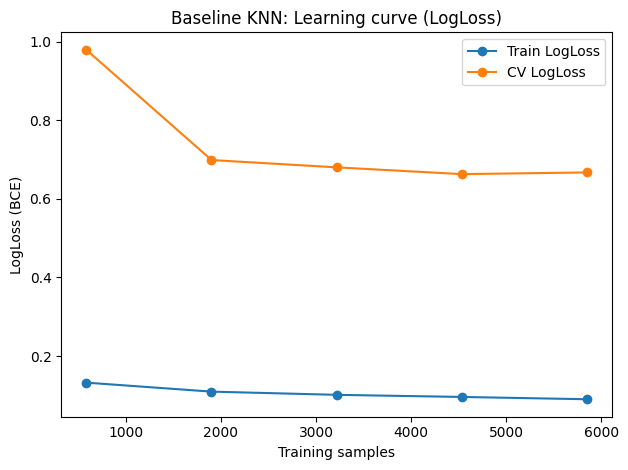

In [45]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes = np.linspace(0.1, 1.0, 5)
ts, tr_scores, cv_scores = learning_curve(
    make_knn(5), X, y, train_sizes=train_sizes, cv=cv,
    scoring="neg_log_loss", n_jobs=-1, shuffle=True, random_state=42
)
plt.figure()
plt.plot(ts, -tr_scores.mean(axis=1), marker="o", label="Train LogLoss")
plt.plot(ts, -cv_scores.mean(axis=1), marker="o", label="CV LogLoss")
plt.xlabel("Training samples"); plt.ylabel("LogLoss (BCE)")
plt.title("Baseline KNN: Learning curve (LogLoss)")
plt.legend(); plt.tight_layout()
plt.savefig("figures/KNN/baseline_knn_learning_curve.pdf", bbox_inches="tight")
plt.show()

## KNN Regularized

In [46]:
# KNN Regularized 

k_reg = 15
weights = "distance"
p = 2

print(f"\n[KNN Regularized k={k_reg}, weights='{weights}']")
print("Config:", {"k": k_reg, "weights": weights, "p": p, "scaler": "StandardScaler"})


knn_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=k_reg, weights=weights, p=p))
])

total_t0 = time.perf_counter()
t0 = time.perf_counter()
knn_reg.fit(X_train, y_train)
train_time = time.perf_counter() - t0


res_knn_reg = evaluate_on_sets(
    knn_reg,
    X_train, y_train,
    X_test,  y_test,
    name=f"KNN Regularized (k={k_reg}, w={weights})",
    train_time=train_time
)


res_knn_reg.update({
    "k": k_reg,
    "weights": weights,
    "p": p,
    "total_time_sec": time.perf_counter() - total_t0
})



[KNN Regularized k=15, weights='distance']
Config: {'k': 15, 'weights': 'distance', 'p': 2, 'scaler': 'StandardScaler'}
[KNN Regularized (k=15, w=distance)] Timings -> total: 0.25s | train: 0.00s | eval: 0.20s
[KNN Regularized (k=15, w=distance)] inference time (test only): 0.041s
Train -> Acc: 1.0000 | AUC: 1.0000 | LogLoss: 0.0000
Test  -> Acc: 0.9344 | AUC: 0.9734 | LogLoss: 0.4557 | Brier: 0.0511
Gaps  -> Acc: +0.0656 | AUC: +0.0266

Classification report (test):
               precision    recall  f1-score   support

         0.0     0.9586    0.9453    0.9519      1005
         1.0     0.8837    0.9107    0.8970       459

    accuracy                         0.9344      1464
   macro avg     0.9212    0.9280    0.9244      1464
weighted avg     0.9351    0.9344    0.9347      1464



In [47]:
k_list = list(range(1, 89, 2)) 
tr_acc, te_acc, tr_ll, te_ll = [], [], [], []
for k in k_list:
    model = make_knn(k).fit(X_train, y_train)
    p_tr = model.predict_proba(X_train)[:,1]; p_te = model.predict_proba(X_test)[:,1]
    tr_acc.append(accuracy_score(y_train, (p_tr>=0.5)))
    te_acc.append(accuracy_score(y_test,  (p_te>=0.5)))
    tr_ll.append(log_loss(y_train, p_tr))
    te_ll.append(log_loss(y_test,  p_te))

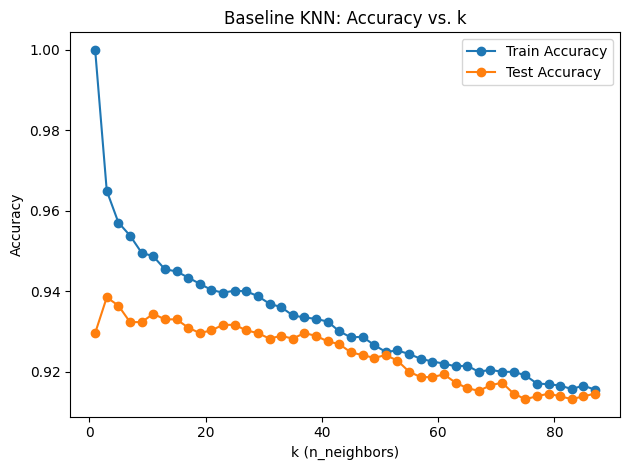

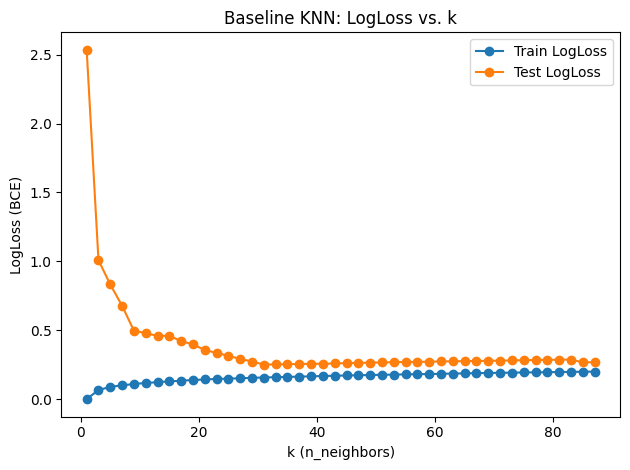

In [48]:
# Plots: Accuracy vs k
plt.figure()
plt.plot(k_list, tr_acc, marker="o", label="Train Accuracy")
plt.plot(k_list, te_acc, marker="o", label="Test Accuracy")
plt.xlabel("k (n_neighbors)"); plt.ylabel("Accuracy")
plt.title("Baseline KNN: Accuracy vs. k")
plt.legend(); plt.tight_layout()
plt.savefig("figures/KNN/baseline_knn_acc_vs_k.pdf", bbox_inches="tight")
plt.show()

# Plots: LogLoss vs k
plt.figure()
plt.plot(k_list, tr_ll, marker="o", label="Train LogLoss")
plt.plot(k_list, te_ll, marker="o", label="Test LogLoss")
plt.xlabel("k (n_neighbors)"); plt.ylabel("LogLoss (BCE)")
plt.title("Baseline KNN: LogLoss vs. k")
plt.legend(); plt.tight_layout()
plt.savefig("figures/KNN/baseline_knn_logloss_vs_k.pdf", bbox_inches="tight")
plt.show()

## KNN — Hyperparameter Tuning (k-sweep) & Final Model

In [49]:
from sklearn.model_selection import cross_validate
def make_knn(k, weights="uniform", p=2):
    return Pipeline([("scaler", StandardScaler()),
                     ("knn", KNeighborsClassifier(n_neighbors=k, weights=weights, p=p))])

k_max = min(int(np.sqrt(len(X_train)) + 20), len(X_train) - 1, 95)
k_values = list(range(1, k_max+1, 2))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
t0 = time.perf_counter()
for k in k_values:
    out = cross_validate(
        make_knn(k), X_train, y_train, cv=cv, n_jobs=-1,
        scoring={"acc": "accuracy", "ll": "neg_log_loss"},
        return_train_score=False
    )
    rows.append({"k": k, "cv_acc": out["test_acc"].mean(),
                       "cv_ll": -out["test_ll"].mean()})
sweep_time = time.perf_counter() - t0

df_knn_cv = pd.DataFrame(rows)
best_k_acc = int(df_knn_cv.loc[df_knn_cv.cv_acc.idxmax(), "k"])
best_k_ll  = int(df_knn_cv.loc[df_knn_cv.cv_ll.idxmin(),  "k"])

ll_min = df_knn_cv.cv_ll.min()
df_ok = df_knn_cv[df_knn_cv.cv_ll <= ll_min * 1.10].sort_values(["cv_acc","k"], ascending=[False, True])
compromise_k = int(df_ok.iloc[0].k) if len(df_ok) else best_k_acc

print(f"[K sweep] k tested={len(k_values)} | folds={cv.get_n_splits()} | runtime={sweep_time:.2f}s")
print(f"Best k by CV Accuracy: {best_k_acc}")
print(f"Best k by CV LogLoss : {best_k_ll}")
print(f"Chosen compromise k  : {compromise_k}")


[K sweep] k tested=48 | folds=5 | runtime=5.37s
Best k by CV Accuracy: 3
Best k by CV LogLoss : 31
Chosen compromise k  : 27


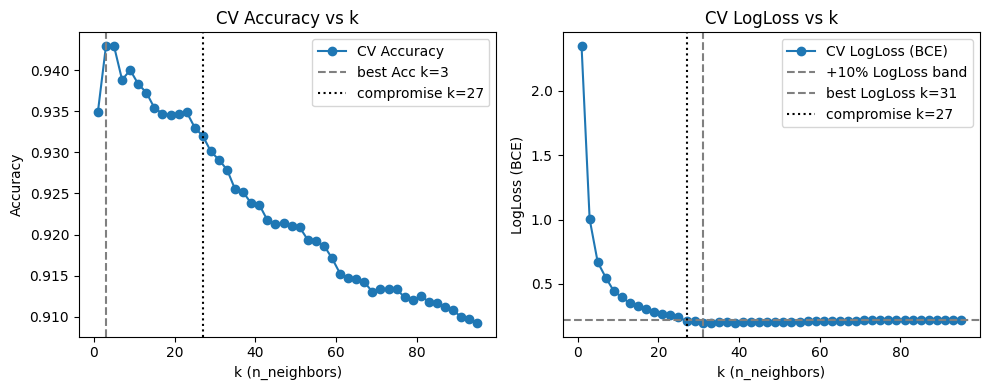

In [50]:
os.makedirs("figures/KNN", exist_ok=True)

k_values = df_knn_cv["k"].to_numpy()
cv_acc   = df_knn_cv["cv_acc"].to_numpy()
cv_ll    = df_knn_cv["cv_ll"].to_numpy()

plt.figure(figsize=(10,4))

# Left: CV Accuracy vs k
plt.subplot(1,2,1)
plt.plot(k_values, cv_acc, marker="o", label="CV Accuracy")
plt.axvline(best_k_acc, color="grey", linestyle="--", label=f"best Acc k={best_k_acc}")
plt.axvline(compromise_k, color="black", linestyle=":", label=f"compromise k={compromise_k}")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Accuracy")
plt.title("CV Accuracy vs k")
plt.legend()

# Right: CV LogLoss vs k
plt.subplot(1,2,2)
plt.plot(k_values, cv_ll, marker="o", label="CV LogLoss (BCE)")
plt.axhline(ll_min * 1.10, color="grey", linestyle="--", label="+10% LogLoss band")
plt.axvline(best_k_ll, color="grey", linestyle="--", label=f"best LogLoss k={best_k_ll}")
plt.axvline(compromise_k, color="black", linestyle=":", label=f"compromise k={compromise_k}")
plt.xlabel("k (n_neighbors)")
plt.ylabel("LogLoss (BCE)")
plt.title("CV LogLoss vs k")
plt.legend()

plt.tight_layout()
plt.savefig("figures/KNN/cv_knn_acc_ll_vs_k.pdf", bbox_inches="tight")
plt.show()


In [51]:
# KNN Final (using shared evaluate_on_sets) 

knn_best = make_knn(compromise_k)

# Train timing
t0 = time.perf_counter()
knn_best.fit(X_train, y_train)
train_time = time.perf_counter() - t0

# Unified evaluation (prints timings, metrics, gaps, classification report)
res_knn_best = evaluate_on_sets(
    knn_best,
    X_train, y_train,
    X_test,  y_test,
    name=f"KNN Final (k={compromise_k})",
    train_time=train_time
)
# pack for summary table
res_knn_best.update({"k": compromise_k})


[KNN Final (k=27)] Timings -> total: 0.30s | train: 0.00s | eval: 0.25s
[KNN Final (k=27)] inference time (test only): 0.050s
Train -> Acc: 0.9400 | AUC: 0.9843 | LogLoss: 0.1515
Test  -> Acc: 0.9303 | AUC: 0.9736 | LogLoss: 0.2925 | Brier: 0.0550
Gaps  -> Acc: +0.0097 | AUC: +0.0107

Classification report (test):
               precision    recall  f1-score   support

         0.0     0.9574    0.9403    0.9488      1005
         1.0     0.8742    0.9085    0.8910       459

    accuracy                         0.9303      1464
   macro avg     0.9158    0.9244    0.9199      1464
weighted avg     0.9314    0.9303    0.9307      1464



In [52]:
from sklearn.metrics import average_precision_score
p_te = knn_best.predict_proba(X_test)[:, 1]
ap = average_precision_score(y_test, p_te)
ece, mce = ece_mce(y_test, p_te)
print(f"AP (PR-AUC): {ap:.4f} | ECE: {ece:.4f} | MCE: {mce:.4f}")
res_knn_best.update({"ap_test": ap, "ece_test": ece, "mce_test": mce})


AP (PR-AUC): 0.9357 | ECE: 0.0195 | MCE: 0.0963


## KNN Summary table

In [53]:
# Summary table for KNN models
rows = [r for r in [globals().get("res_knn_base"),
                    globals().get("res_knn_reg"),
                    globals().get("res_knn_best")] if isinstance(r, dict)]
summary_knn = pd.DataFrame(rows)[
    ["name","k","acc_train","acc_test","auc_train","auc_test","ll_train","ll_test","brier_test"]
]

display(summary_knn)


,name,k,acc_train,acc_test,auc_train,auc_test,ll_train,ll_test,brier_test
0,KNN Baseline (k=5),5,0.957109,0.936475,0.993704,0.967487,8.863631e-02,0.832102,0.051885
1,"KNN Regularized (k=15, w=distance)",15,1.000000,0.934426,1.000000,0.973352,2.220446e-16,0.455706,0.051105
2,KNN Final (k=27),27,0.940021,0.930328,0.984294,0.973587,1.515020e-01,0.292467,0.055043


# Models Comparison

## Funcions and Setup

In [54]:
# No retraining is performed. This cell only evaluates/predicts.

from sklearn.metrics import (
    accuracy_score, roc_auc_score, log_loss, brier_score_loss,
    average_precision_score, precision_recall_curve, roc_curve
)
from sklearn.calibration import calibration_curve

# Sanity checks 
assert all(v in globals() for v in
           ["mlp_best","rf_best","knn_best",
            "X_train_s","X_test_s","X_train","X_test","y_train","y_test"]), \
       "One or more required variables are missing."

MLP_MODEL = mlp_best
RF_MODEL  = rf_best
KNN_MODEL = knn_best

os.makedirs("figures", exist_ok=True)
os.makedirs("figures/compare", exist_ok=True)

# Evaluators (Keras vs scikit-learn) 
def eval_keras_binary(model, Xtr, ytr, Xte, yte, name):
    """Evaluate a Keras binary classifier that outputs probabilities via model.predict (no training here)."""
    p_tr = model.predict(Xtr, verbose=0).ravel()
    p_te = model.predict(Xte, verbose=0).ravel()
    ytr_hat = (p_tr >= 0.5).astype(int)
    yte_hat = (p_te >= 0.5).astype(int)
    return {
        "name": name,
        "acc_train": accuracy_score(ytr, ytr_hat),
        "acc_test":  accuracy_score(yte, yte_hat),
        "auc_train": roc_auc_score(ytr, p_tr),
        "auc_test":  roc_auc_score(yte, p_te),
        "ll_train":  log_loss(ytr, p_tr),
        "ll_test":   log_loss(yte, p_te),
        "brier_test": brier_score_loss(yte, p_te),
        "ap_test":   average_precision_score(yte, p_te),
        "p_tr": p_tr, "p_te": p_te
    }

def eval_sklearn_binary(model, Xtr, ytr, Xte, yte, name):
    """Evaluate a scikit-learn classifier with predict_proba for class 1 (no training here)."""
    p_tr = model.predict_proba(Xtr)[:, 1]
    p_te = model.predict_proba(Xte)[:, 1]
    ytr_hat = (p_tr >= 0.5).astype(int)
    yte_hat = (p_te >= 0.5).astype(int)
    return {
        "name": name,
        "acc_train": accuracy_score(ytr, ytr_hat),
        "acc_test":  accuracy_score(yte, yte_hat),
        "auc_train": roc_auc_score(ytr, p_tr),
        "auc_test":  roc_auc_score(yte, p_te),
        "ll_train":  log_loss(ytr, p_tr),
        "ll_test":   log_loss(yte, p_te),
        "brier_test": brier_score_loss(yte, p_te),
        "ap_test":   average_precision_score(yte, p_te),
        "p_tr": p_tr, "p_te": p_te
    }

# If summaries exist, reuse them; otherwise compute from models (still no training)
def _maybe_to_dict(obj):
    if obj is None: return None
    if hasattr(obj, "to_dict"): return obj.to_dict()
    if isinstance(obj, dict):   return dict(obj)
    return None

_exist_mlp = _maybe_to_dict(globals().get("mlp_res_tuned"))
_exist_rf  = _maybe_to_dict(globals().get("rf_res_tuned"))
_exist_knn = _maybe_to_dict(globals().get("res_knn_best"))

if _exist_mlp is None or "p_te" not in _exist_mlp:
    res_mlp = eval_keras_binary(MLP_MODEL, X_train_s, y_train, X_test_s, y_test,
                                name=_exist_mlp.get("name","MLP (tuned)") if _exist_mlp else "MLP (tuned)")
else:
    res_mlp = _exist_mlp

if _exist_rf is None or "p_te" not in _exist_rf:
    res_rf = eval_sklearn_binary(RF_MODEL, X_train, y_train, X_test, y_test,
                                 name=_exist_rf.get("name","RF (tuned)") if _exist_rf else "RF (tuned)")
else:
    res_rf = _exist_rf

if _exist_knn is None or "p_te" not in _exist_knn:
    res_knn = eval_sklearn_binary(KNN_MODEL, X_train, y_train, X_test, y_test,
                                  name=_exist_knn.get("name","KNN (final)") if _exist_knn else "KNN (final)")
else:
    res_knn = _exist_knn

# Ensure probabilities exist for curves/calibration
assert all("p_te" in r for r in (res_mlp, res_rf, res_knn)), "Missing p_te probabilities for ROC/PR/Calibration."

# Calibration: ECE/MCE (quantile bins; robust to ties) 
def ece_mce(y_true, proba, n_bins=10, strategy="quantile"):
    frac_pos, mean_pred = calibration_curve(y_true, proba, n_bins=n_bins, strategy=strategy)
    
    # Use same binning as calibration_curve
    if strategy == "quantile":
        edges = np.quantile(proba, np.linspace(0, 1, n_bins + 1))
    else:
        edges = np.linspace(0, 1, n_bins + 1)
    
    # Assign each probability to a bin
    bin_ids = np.digitize(proba, edges[1:-1], right=True)
    
    # Count samples per bin (same number of bins as frac_pos length)
    counts = np.array([np.sum(bin_ids == i) for i in range(len(frac_pos))], dtype=float)
    
    # Normalize weights so sum = 1
    weights = counts / counts.sum()
    
    diff = np.abs(frac_pos - mean_pred)
    ece = float(np.sum(diff * weights))
    mce = float(np.max(diff))
    return ece, mce


for res in (res_mlp, res_rf, res_knn):
    ece, mce = ece_mce(y_test, res["p_te"], n_bins=10, strategy="quantile")
    res["ece_test"] = ece
    res["mce_test"] = mce

#  Inference time (total and per-sample ms); still no training 
def time_predict_total(predict_fn, X):
    _ = predict_fn(X[:min(128, len(X))])  # warm-up to avoid lazy init overhead
    t0 = time.perf_counter(); _ = predict_fn(X); t1 = time.perf_counter()
    total = t1 - t0
    return total, (total / len(X)) * 1000.0

mlp_s, mlp_ms = time_predict_total(lambda X: MLP_MODEL.predict(X, verbose=0).ravel(), X_test_s)
rf_s,  rf_ms  = time_predict_total(lambda X: RF_MODEL.predict_proba(X)[:, 1],       X_test)
knn_s, knn_ms = time_predict_total(lambda X: KNN_MODEL.predict_proba(X)[:, 1],      X_test)

res_mlp.update({"infer_s": mlp_s, "infer_ms": mlp_ms})
res_rf.update( {"infer_s": rf_s,  "infer_ms": rf_ms})
res_knn.update({"infer_s": knn_s, "infer_ms": knn_ms})

## Test result comparison

In [55]:
# Tables: (A) test-only

test_summary = pd.DataFrame([res_mlp, res_rf, res_knn])[[
    "name","acc_test","auc_test","ll_test","brier_test","ap_test",
    "ece_test","mce_test","infer_s","infer_ms"
]].rename(columns={
    "name":"Model",
    "acc_test":"Accuracy (test)", "auc_test":"AUC (test)", "ll_test":"LogLoss (test)",
    "brier_test":"Brier (test)", "ap_test":"AP (test)",
    "ece_test":"ECE (test)", "mce_test":"MCE (test)",
    "infer_s":"Inf time (s)", "infer_ms":"Inf ms/sample"
})


try:
    display(test_summary.style.format({
        "Accuracy (test)":"{:.4f}", "AUC (test)":"{:.4f}", "LogLoss (test)":"{:.4f}",
        "Brier (test)":"{:.4f}", "AP (test)":"{:.4f}",
        "ECE (test)":"{:.4f}", "MCE (test)":"{:.4f}",
        "Inf time (s)":"{:.3f}", "Inf ms/sample":"{:.3f}"
    }).set_caption("Test-only summary"))
except Exception:
    print(test_summary.to_string(index=False))


test_summary.to_csv("figures/compare/test_summary.csv", index=False)
    

,Model,Accuracy (test),AUC (test),LogLoss (test),Brier (test),AP (test),ECE (test),MCE (test),Inf time (s),Inf ms/sample
0,Tuned MLP,0.9508,0.9860,0.1452,0.0363,0.9740,0.0173,0.0513,0.043,0.029
1,RF Final (OOB-tuned),0.9645,0.9906,0.1098,0.0278,0.9832,0.0194,0.0723,0.083,0.057
2,KNN Final (k=27),0.9303,0.9736,0.2925,0.0550,0.9357,0.0121,0.0589,0.051,0.035


## Comparison with train/test gap

In [56]:
# Tables: (B) train+test+gaps 

both = pd.DataFrame([res_mlp, res_rf, res_knn])[[
    "name","acc_train","acc_test","auc_train","auc_test","ll_train","ll_test",
    "brier_test","ap_test","ece_test","mce_test","infer_s","infer_ms"
]].rename(columns={
    "name":"Model",
    "acc_train":"Accuracy (train)", "acc_test":"Accuracy (test)",
    "auc_train":"AUC (train)",      "auc_test":"AUC (test)",
    "ll_train":"LogLoss (train)",   "ll_test":"LogLoss (test)",
    "brier_test":"Brier (test)", "ap_test":"AP (test)",
    "ece_test":"ECE (test)",    "mce_test":"MCE (test)",
    "infer_s":"Inf time (s)",   "infer_ms":"Inf ms/sample"
})

# Generalization gaps
both["ΔAccuracy (train - test)"] = both["Accuracy (train)"] - both["Accuracy (test)"]
both["ΔAUC (train - test)"]      = both["AUC (train)"]      - both["AUC (test)"]
both["ΔLogLoss (test - train)"]  = both["LogLoss (test)"]   - both["LogLoss (train)"]

# Display + CSV backup
try:
    display(both[[
        "Model",
        "Accuracy (train)", "Accuracy (test)", "ΔAccuracy (train - test)",
        "AUC (train)", "AUC (test)", "ΔAUC (train - test)",
        "LogLoss (train)", "LogLoss (test)", "ΔLogLoss (test - train)",
        "Brier (test)", "AP (test)", "ECE (test)", "MCE (test)",
        "Inf time (s)", "Inf ms/sample"
    ]].style.format({
        "Accuracy (train)":"{:.4f}", "Accuracy (test)":"{:.4f}", "ΔAccuracy (train - test)":"{:+.4f}",
        "AUC (train)":"{:.4f}", "AUC (test)":"{:.4f}", "ΔAUC (train - test)":"{:+.4f}",
        "LogLoss (train)":"{:.4f}", "LogLoss (test)":"{:.4f}", "ΔLogLoss (test - train)":"{:+.4f}",
        "Brier (test)":"{:.4f}", "AP (test)":"{:.4f}", "ECE (test)":"{:.4f}", "MCE (test)":"{:.4f}",
        "Inf time (s)":"{:.3f}", "Inf ms/sample":"{:.3f}"
    }).set_caption("Train vs Test with generalization gaps"))
except Exception:
    print(both.to_string(index=False))


both.to_csv("figures/compare/train_test_gaps.csv", index=False)

,Model,Accuracy (train),Accuracy (test),ΔAccuracy (train - test),AUC (train),AUC (test),ΔAUC (train - test),LogLoss (train),LogLoss (test),ΔLogLoss (test - train),Brier (test),AP (test),ECE (test),MCE (test),Inf time (s),Inf ms/sample
0,Tuned MLP,0.9639,0.9508,+0.0131,0.9939,0.9860,+0.0080,0.0965,0.1452,+0.0487,0.0363,0.9740,0.0173,0.0513,0.043,0.029
1,RF Final (OOB-tuned),0.9935,0.9645,+0.0290,0.9998,0.9906,+0.0092,0.0461,0.1098,+0.0637,0.0278,0.9832,0.0194,0.0723,0.083,0.057
2,KNN Final (k=27),0.9400,0.9303,+0.0097,0.9843,0.9736,+0.0107,0.1515,0.2925,+0.1410,0.0550,0.9357,0.0121,0.0589,0.051,0.035


## ROC Curve Comparison

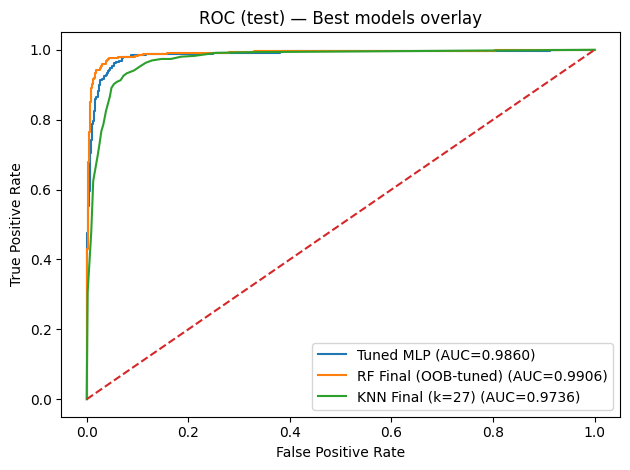

In [57]:
# Plots: ROC, PR, Calibration (saved to figures/compare/) 

plt.figure()
for res in [res_mlp, res_rf, res_knn]:
    fpr, tpr, _ = roc_curve(y_test, res["p_te"])
    auc_val = roc_auc_score(y_test, res["p_te"])
    plt.plot(fpr, tpr, label=f"{res['name']} (AUC={auc_val:.4f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC (test) — Best models overlay"); plt.legend(); plt.tight_layout()
plt.savefig("figures/compare/roc_overlay.pdf"); plt.savefig("figures/compare/roc_overlay.png", dpi=200)
plt.show()

## Precision -Recall Comparison

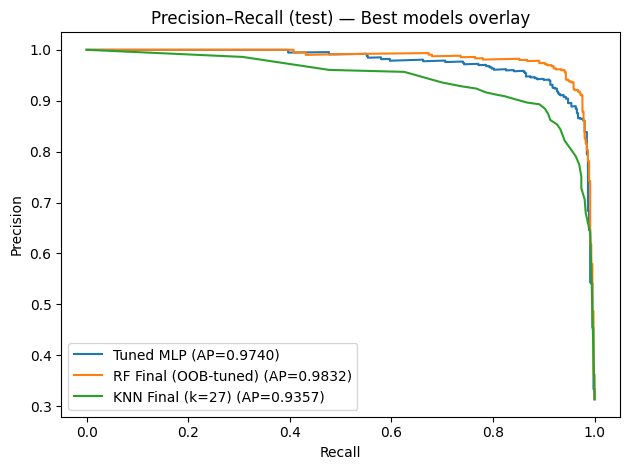

In [58]:
plt.figure()
for res in [res_mlp, res_rf, res_knn]:
    prec, rec, _ = precision_recall_curve(y_test, res["p_te"])
    ap_val = average_precision_score(y_test, res["p_te"])
    plt.plot(rec, prec, label=f"{res['name']} (AP={ap_val:.4f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall (test) — Best models overlay"); plt.legend(); plt.tight_layout()
plt.savefig("figures/compare/pr_overlay.pdf"); plt.savefig("figures/compare/pr_overlay.png", dpi=200)
plt.show()

## Reliability Comparison

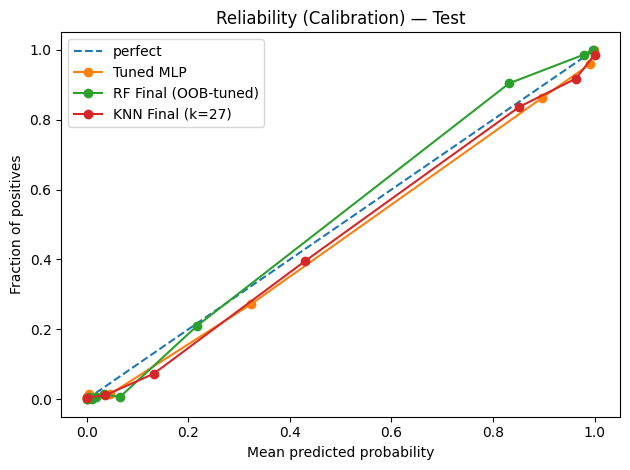

In [59]:
plt.figure()
plt.plot([0,1],[0,1],"--", label="perfect")
for res in [res_mlp, res_rf, res_knn]:
    frac_pos, mean_pred = calibration_curve(y_test, res["p_te"], n_bins=10, strategy="quantile")
    plt.plot(mean_pred, frac_pos, marker="o", label=res["name"])
plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives")
plt.title("Reliability (Calibration) — Test"); plt.legend(); plt.tight_layout()
plt.savefig("figures/compare/calibration_overlay.pdf"); plt.savefig("figures/compare/calibration_overlay.png", dpi=200)
plt.show()

# Threshold analysis and Confusion Matrices

### functions and def

In [60]:
# No retraining and no new inference is performed.

from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score


# Safety: ensure required objects exist
for _name, _res in [("MLP", res_mlp), ("RF", res_rf), ("KNN", res_knn)]:
    if "p_te" not in _res:
        raise RuntimeError(f"Missing p_te in {_name} results. Threshold analysis needs test probabilities.")
if "y_test" not in globals():
    raise RuntimeError("Missing y_test (ground-truth labels).")

os.makedirs("figures/compare", exist_ok=True)
y_true = y_test  # ground-truth test labels

def best_thresholds(y_true, p):
    """Return Youden's J threshold, max-F1 threshold, a threshold grid, and F1 values."""
    # Youden's J from ROC: J = TPR - FPR
    fpr, tpr, thr = roc_curve(y_true, p)
    t_j = float(thr[int(np.argmax(tpr - fpr))])

    # Max F1 on a simple threshold grid (0.01..0.99)
    ts = np.linspace(0.01, 0.99, 99)
    f1s = [f1_score(y_true, (p >= t).astype(int), zero_division=0) for t in ts]
    t_f1 = float(ts[int(np.argmax(f1s))])
    return t_j, t_f1, ts, f1s

def cm_print(y_true, p, t, tag):
    """Print confusion matrix + Accuracy/F1/Precision/Recall at threshold t."""
    yhat = (p >= t).astype(int)
    cm = confusion_matrix(y_true, yhat, labels=[0, 1])
    acc  = accuracy_score(y_true, yhat)
    f1   = f1_score(y_true, yhat, zero_division=0)
    prec = precision_score(y_true, yhat, zero_division=0)
    rec  = recall_score(y_true, yhat, zero_division=0)
    print(f"{tag} @ t={t:.3f} | Acc={acc:.4f}  F1={f1:.4f}  Prec={prec:.4f}  Rec={rec:.4f}\n{cm}\n")


## best thresholds per model

In [61]:
# Compute best thresholds per model
tj_mlp, tf1_mlp, ts, f1s_mlp = best_thresholds(y_true, res_mlp["p_te"])
tj_rf,  tf1_rf,  _,  f1s_rf  = best_thresholds(y_true, res_rf["p_te"])
tj_knn, tf1_knn, _,  f1s_knn = best_thresholds(y_true, res_knn["p_te"])

print(
    "Best thresholds:\n"
    f"  MLP J={tj_mlp:.3f}, F1*={tf1_mlp:.3f}\n"
    f"  RF  J={tj_rf:.3f},  F1*={tf1_rf:.3f}\n"
    f"  KNN J={tj_knn:.3f}, F1*={tf1_knn:.3f}\n"
)

# Confusion matrices at t=0.50 and at max-F1
cm_print(y_true, res_mlp["p_te"], 0.50,    "MLP (tuned)")
cm_print(y_true, res_mlp["p_te"], tf1_mlp, "MLP (tuned) F1*")

cm_print(y_true, res_rf["p_te"],  0.50,    "RF  (tuned)")
cm_print(y_true, res_rf["p_te"],  tf1_rf,  "RF  (tuned) F1*")

cm_print(y_true, res_knn["p_te"], 0.50,    "KNN (final)")
cm_print(y_true, res_knn["p_te"], tf1_knn, "KNN (final) F1*")


Best thresholds:
  MLP J=0.356, F1*=0.630
  RF  J=0.220,  F1*=0.400
  KNN J=0.407, F1*=0.520

MLP (tuned) @ t=0.500 | Acc=0.9508  F1=0.9222  Prec=0.9143  Rec=0.9303
[[965  40]
 [ 32 427]]

MLP (tuned) F1* @ t=0.630 | Acc=0.9542  F1=0.9260  Prec=0.9395  Rec=0.9129
[[978  27]
 [ 40 419]]

RF  (tuned) @ t=0.500 | Acc=0.9645  F1=0.9421  Prec=0.9636  Rec=0.9216
[[989  16]
 [ 36 423]]

RF  (tuned) F1* @ t=0.400 | Acc=0.9686  F1=0.9496  Prec=0.9558  Rec=0.9434
[[985  20]
 [ 26 433]]

KNN (final) @ t=0.500 | Acc=0.9303  F1=0.8910  Prec=0.8742  Rec=0.9085
[[945  60]
 [ 42 417]]

KNN (final) F1* @ t=0.520 | Acc=0.9324  F1=0.8932  Prec=0.8846  Rec=0.9020
[[951  54]
 [ 45 414]]



## F1 vs Threshold plot

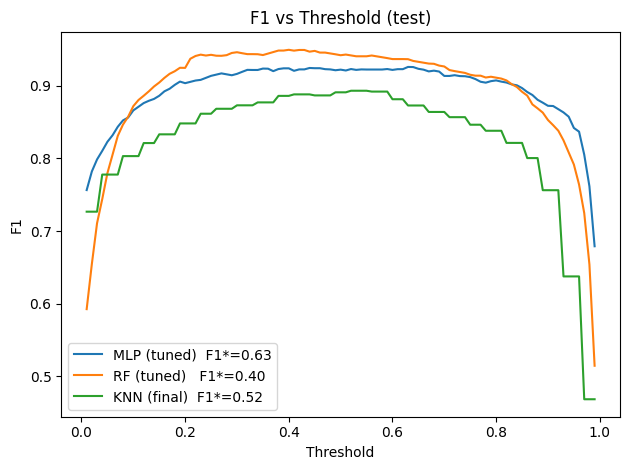

In [62]:
plt.figure()
plt.plot(ts, f1s_mlp, label=f"MLP (tuned)  F1*={tf1_mlp:.2f}")
plt.plot(ts, f1s_rf,  label=f"RF (tuned)   F1*={tf1_rf:.2f}")
plt.plot(ts, f1s_knn, label=f"KNN (final)  F1*={tf1_knn:.2f}")
plt.xlabel("Threshold"); plt.ylabel("F1")
plt.title("F1 vs Threshold (test)")
plt.legend(); plt.tight_layout()

plt.savefig("figures/compare/f1_vs_threshold.pdf")
plt.show()



# Misclassification Analysis

In [63]:
def get_misclassified_examples(model, X, y_true, model_name="Model", threshold=0.5):
    """
    Returns a DataFrame containing ONLY the examples that the model misclassified.

    Columns included:
    - Feature values (from X)
    - True Label (ground truth)
    - Predicted (0/1 predicted class based on threshold)
    - Confidence (predicted probability for class 1)
    - Model (model name for tracking)
    - Error Type (False Positive / False Negative)
    """
    # 1) Get predicted probabilities (handle differences between scikit-learn and Keras/TF)
    if hasattr(model, "predict_proba"):
        # scikit-learn models (e.g., RandomForest, KNN) usually support predict_proba
        probas = model.predict_proba(X)[:, 1]  # probability of class 1
    else:
        # Keras/TF models typically use predict() and return probabilities directly
        probas = model.predict(X, verbose=0).ravel()

    # 2) Convert probabilities to binary class predictions (0 or 1) using a decision threshold
    y_pred = (probas >= threshold).astype(int)

    # 3) Identify indices where the prediction is incorrect
    # Ensure y_true is a flat 1D array
    y_true_flat = np.asarray(y_true).ravel()
    mistakes_mask = (y_pred != y_true_flat)

    # 4) Extract misclassified examples and build a results DataFrame
    # If X is a NumPy array, convert the misclassified rows to a DataFrame for readability.
    # If you have original feature names, you can pass them via columns=feature_names.
    X_mistakes = pd.DataFrame(X[mistakes_mask])

    results = X_mistakes.copy()
    results["True Label"] = y_true_flat[mistakes_mask]
    results["Predicted"] = y_pred[mistakes_mask]
    results["Confidence"] = probas[mistakes_mask]  # how confident the model was (even though it was wrong)
    results["Model"] = model_name

    # 5) Label the type of error:
    # FP (False Positive): predicted 1, true label 0
    # FN (False Negative): predicted 0, true label 1
    results["Error Type"] = np.where(
        results["Predicted"] == 1,
        "False Positive (FP)",
        "False Negative (FN)"
    )

    return results


# --- Example usage ---
# Prefer using the original (non-normalized) X_test for better interpretability in the output table.
# For models that were trained on scaled features (like an MLP), use the scaled test set (X_test_s).
errors_rf  = get_misclassified_examples(rf_best,  X_test,   y_test, model_name="Random Forest")
errors_mlp = get_misclassified_examples(mlp_best, X_test_s, y_test, model_name="MLP")
errors_knn = get_misclassified_examples(knn_best, X_test,   y_test, model_name="KNN")

print(f"Total RF errors found: {len(errors_rf)}")

display(errors_rf.describe())
display(errors_mlp.describe())
display(errors_knn.describe())


Total RF errors found: 52


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,True Label,Predicted,Confidence
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.115385,0.038462,20.929272,149.849792,0.495254,5.092156,1127.316040,4.898293,1157.079346,926.681885,46.709614,5697.125000,4.313779,1.219031,13.884375,0.692308,0.307692,0.422650
std,0.322603,0.194184,29.377544,29.701277,0.337544,3.498051,1838.677246,8.923798,629.786621,1119.406616,67.245911,616.604431,0.306064,0.509993,1.374602,0.466041,0.466041,0.275206
min,0.000000,0.000000,0.341842,131.580673,0.002000,0.444500,12.200000,0.270000,209.000000,0.450000,6.800000,4196.500000,3.746500,0.148000,10.565750,0.000000,0.000000,0.003611
25%,0.000000,0.000000,2.140528,132.474262,0.194250,2.113100,91.875000,1.250000,715.750000,61.912499,12.350000,5261.000000,4.093750,0.858500,13.254500,0.000000,0.000000,0.233909
50%,0.000000,0.000000,6.710906,134.232277,0.468450,4.227050,276.199997,1.975000,1071.500000,313.035004,17.750000,5879.000000,4.412500,1.067000,14.029500,1.000000,0.000000,0.378603
75%,0.000000,0.000000,21.188467,148.097149,0.789250,7.333500,984.675003,3.202500,1711.250000,2026.767517,45.999999,6174.500000,4.546750,1.586250,14.828500,1.000000,1.000000,0.569608
max,1.000000,1.000000,87.105453,228.323883,1.228000,12.289150,5385.612305,56.651249,2797.125000,2761.297607,255.762497,6642.000000,5.014500,2.078375,15.920000,1.000000,1.000000,0.986914


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,True Label,Predicted,Confidence
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,7.200000e+01
mean,-0.468186,-0.526509,0.151056,0.072134,-0.235539,0.059891,-0.433147,-0.538622,-0.172745,-0.068568,-0.504364,-0.120610,-0.027932,0.043787,-0.115286,0.444444,0.555556,5.593109e-01
std,0.608913,0.378134,1.063232,1.088738,0.835296,0.968902,0.589636,0.357246,0.887451,0.980837,0.571155,0.976170,1.069433,1.073287,1.052343,0.500391,0.500391,2.938499e-01
min,-0.650501,-0.589980,-0.784399,-0.904612,-1.433799,-1.366838,-0.775200,-0.708971,-1.372691,-0.721608,-0.802171,-2.297493,-2.266815,-2.200720,-2.749418,0.000000,0.000000,1.029152e-09
25%,-0.650501,-0.589980,-0.699568,-0.697161,-0.979368,-0.737786,-0.736118,-0.654438,-0.892599,-0.709470,-0.754937,-0.794735,-0.555508,-0.697968,-0.741727,0.000000,0.000000,3.650299e-01
50%,-0.650501,-0.589980,-0.383706,-0.488806,-0.194772,-0.092049,-0.643766,-0.617871,-0.281640,-0.572123,-0.699065,0.098142,0.305727,-0.306718,-0.028393,0.000000,1.000000,5.351456e-01
75%,-0.650501,-0.589980,0.901588,0.370235,0.508672,0.509543,-0.378546,-0.573207,0.425631,0.113885,-0.577334,0.579388,0.731694,0.553030,0.809831,1.000000,1.000000,8.021522e-01
max,1.537276,1.694973,1.952662,2.338289,1.527307,2.210208,1.817496,2.144541,2.516750,2.008892,1.906267,2.333362,2.450441,2.090517,1.224953,1.000000,1.000000,9.949321e-01


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,True Label,Predicted,Confidence
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,0.058824,0.019608,30.889526,153.733841,0.467495,5.916976,839.437988,4.467855,951.040466,581.193726,35.624023,5656.921387,4.364863,1.130115,14.297665,0.411765,0.588235,0.563544
std,0.236456,0.139333,34.693424,31.281565,0.341654,3.716683,1350.844971,8.092335,555.466309,900.228088,55.490910,590.621826,0.272792,0.459275,1.343518,0.494583,0.494583,0.285874
min,0.000000,0.000000,0.341842,131.608093,0.002000,0.444500,21.100000,0.400000,172.000000,0.210000,2.400000,4196.500000,3.746500,0.148000,10.565750,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.231350,132.527489,0.160300,2.482425,109.874998,1.135000,469.500000,11.505000,9.800000,5306.500000,4.240250,0.831750,13.315750,0.000000,0.000000,0.333333
50%,0.000000,0.000000,11.667391,136.542061,0.452000,5.504500,283.400009,1.850000,920.500000,160.400002,15.900000,5775.250000,4.438000,0.999500,14.635500,0.000000,1.000000,0.555556
75%,0.000000,0.000000,66.453980,162.906445,0.751000,8.651250,934.775024,3.112500,1234.750000,548.842514,30.750000,6092.750000,4.552500,1.335000,15.438750,1.000000,1.000000,0.842593
max,1.000000,1.000000,87.105453,228.323883,1.228000,12.289150,5385.612305,56.651249,2797.125000,2761.297607,255.762497,6561.000000,5.014500,2.078375,15.920000,1.000000,1.000000,1.000000


In [64]:
# --- Step 1: Retrieve original indices of errors for each model ---
# We recompute predictions to recover the exact row indices (positions) in the test set
# where each model made a mistake.

# 1) Random Forest error indices
# Convert probabilities to class labels using threshold=0.5
y_pred_rf = (rf_best.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
idx_rf = set(np.where(y_pred_rf != y_test)[0])

# 2) MLP error indices
# IMPORTANT: Neural networks typically require the scaled test data (X_test_s)
y_pred_mlp = (mlp_best.predict(X_test_s, verbose=0).ravel() >= 0.5).astype(int)
idx_mlp = set(np.where(y_pred_mlp != y_test)[0])

# 3) KNN error indices
# KNN in scikit-learn supports predict_proba for probability outputs
y_pred_knn = (knn_best.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
idx_knn = set(np.where(y_pred_knn != y_test)[0])


# --- Step 2: Set operations (finding shared and unique errors) ---

# A) INTERSECTION: examples misclassified by ALL models ("hard cases")
# Indices that appear in RF errors AND MLP errors AND KNN errors
hard_examples_idx = idx_rf.intersection(idx_mlp).intersection(idx_knn)

# B) RF ONLY: examples misclassified only by Random Forest
# (RF errors) minus (MLP errors) minus (KNN errors)
rf_only_idx = idx_rf - idx_mlp - idx_knn

# C) MLP ONLY: examples misclassified only by the neural network
# (MLP errors) minus (RF errors) minus (KNN errors)
mlp_only_idx = idx_mlp - idx_rf - idx_knn

# D) KNN ONLY: examples misclassified only by KNN
# (KNN errors) minus (RF errors) minus (MLP errors)
knn_only_idx = idx_knn - idx_rf - idx_mlp


# --- Step 3: Reporting (counts of overlaps/uniques) ---

print(f"--- Error Overlap Analysis ---")
print(f"Shared by ALL (Hard Cases): {len(hard_examples_idx)}")
print("-" * 30)
print(f"Unique to RF:  {len(rf_only_idx)}")
print(f"Unique to MLP: {len(mlp_only_idx)}")
print(f"Unique to KNN: {len(knn_only_idx)}")
print("=" * 30)


# --- Step 4: Displaying examples (optional) ---

def show_examples(indices, title, X_ref=X_test, y_ref=y_test, top_n=5):
    """
    Display a small sample of rows (default top 5) from the ORIGINAL feature space (X_test)
    for the provided index set, alongside the true labels.

    Notes:
    - We default to X_test (unscaled) for readability.
    - If X_test is a NumPy array, columns will be numbered 0..d-1 unless you pass feature names.
    """
    if len(indices) == 0:
        print(f"\n>>> {title}: None found.")
        return

    print(f"\n>>> {title} (Top {top_n} examples):")

    # Convert set -> sorted list for reproducible ordering
    idx_list = sorted(list(indices))[:top_n]

    # Build a display DataFrame
    df_show = pd.DataFrame(X_ref[idx_list])
    df_show["True Label"] = np.asarray(y_ref).ravel()[idx_list]

    display(df_show)


# Uncomment to show samples
# show_examples(hard_examples_idx, "Hard Examples (Failed by everyone)")
# show_examples(rf_only_idx,       "RF Unique Failures")
# show_examples(mlp_only_idx,      "MLP Unique Failures")
# show_examples(knn_only_idx,      "KNN Unique Failures")


--- Error Overlap Analysis ---
Shared by ALL (Hard Cases): 25
------------------------------
Unique to RF:  10
Unique to MLP: 14
Unique to KNN: 41


In [65]:
# Try to recover feature (column) names from the original DataFrame
# Assumption: the target column is called 'label' (as in your notebook)

try:
    # Option A: df is still available in memory
    feature_names = df.drop(columns=["label"]).columns.tolist()
    print("Successfully retrieved feature names from memory.")
except Exception:
    # Option B: df was overwritten / not available; reload the CSV just to read headers
    print("Reloading headers from CSV file...")
    temp_df = pd.read_csv("data/kepler_model_ready.csv")  # use your processed dataset filename
    feature_names = temp_df.drop(columns=["label"]).columns.tolist()

print(f"Total features: {len(feature_names)}")
print("First 5 features:", feature_names[:5])


Successfully retrieved feature names from memory.
Total features: 15
First 5 features: ['koi_fpflag_ss', 'koi_fpflag_co', 'koi_period', 'koi_time0bk', 'koi_impact']


In [66]:
def analyze_group_stats(X_test, indices_dict, feature_names=None):
    """
    Compares the mean feature values of specific error groups against the global average.
    """
    # 1. Calculate Global Mean (Benchmark)
    # This represents the "average" planet candidate in your test set
    global_mean = pd.DataFrame(X_test).mean()
    
    analysis_results = []
    
    print(f"{'Group Name':<25} | {'Feature Name':<20} | {'Group Mean':<10} | {'Global Mean':<10} | {'Deviation':<10}")
    print("-" * 95)
    
    # 2. Loop through each error group (Hard, RF_only, etc.)
    for group_name, idx_set in indices_dict.items():
        if len(idx_set) == 0:
            continue
            
        # Extract the data for this specific group
        group_data = pd.DataFrame(X_test[list(idx_set)])
        group_mean = group_data.mean()
        
        # 3. Calculate Deviation (%)
        # How much does this group differ from the average?
        # Formula: (GroupMean - GlobalMean) / GlobalMean
        deviation = ((group_mean - global_mean) / global_mean) * 100
        
        # 4. Find the Top 3 most deviant features for this group
        # We look for the largest absolute differences
        top_deviations = deviation.abs().sort_values(ascending=False)
        
        for feat_idx in top_deviations.index:
            # Get readable name if available, else use index
            feat_name = feature_names[feat_idx] if feature_names else f"Feature {feat_idx}"
            
            val_group = group_mean[feat_idx]
            val_global = global_mean[feat_idx]
            dev_val = deviation[feat_idx]
            
            print(f"{group_name:<25} | {feat_name:<20} | {val_group:>10.2f} | {val_global:>10.2f} | {dev_val:>+9.1f}%")
        print("-" * 95)

In [67]:
# Define the groups to analyze (same as before)
groups_to_analyze = {
    "HARD Examples (All fail)": hard_examples_idx,
    "RF Unique Failures": rf_only_idx,
    "MLP Unique Failures": mlp_only_idx,
    "KNN Unique Failures": knn_only_idx
}

# --- The only change is the last line ---
# We pass the feature_names we recovered above so the output uses real column names
analyze_group_stats(X_test, groups_to_analyze, feature_names=feature_names)


Group Name                | Feature Name         | Group Mean | Global Mean | Deviation 
-----------------------------------------------------------------------------------------------
HARD Examples (All fail)  | koi_fpflag_co        |       0.08 |       0.24 |     -66.8%
HARD Examples (All fail)  | koi_prad             |       5.45 |      14.50 |     -62.4%
HARD Examples (All fail)  | koi_fpflag_ss        |       0.12 |       0.30 |     -60.3%
HARD Examples (All fail)  | koi_model_snr        |      42.15 |      79.94 |     -47.3%
HARD Examples (All fail)  | koi_depth            |     995.92 |    1631.46 |     -39.0%
HARD Examples (All fail)  | koi_insol            |    1042.26 |     779.11 |     +33.8%
HARD Examples (All fail)  | koi_period           |      21.75 |      24.18 |     -10.0%
HARD Examples (All fail)  | koi_teq              |    1179.89 |    1119.02 |      +5.4%
HARD Examples (All fail)  | koi_duration         |       5.29 |       5.04 |      +4.9%
HARD Examples (All fail

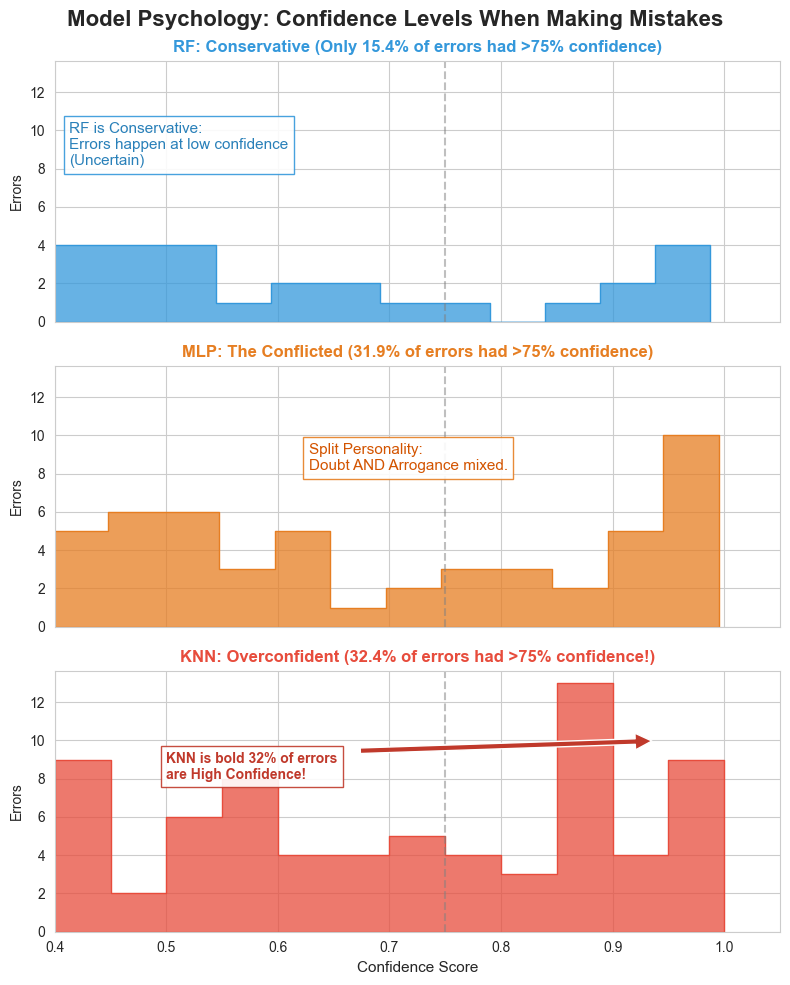

In [ ]:
# 1. Data Preparation
rf_data = errors_rf[['Confidence']].copy()
mlp_data = errors_mlp[['Confidence']].copy()
knn_data = errors_knn[['Confidence']].copy()

def calculate_high_conf_pct(df, threshold=0.75):
    total_errors = len(df)
    if total_errors == 0: return 0
    high_conf_errors = len(df[df['Confidence'] > threshold])
    return (high_conf_errors / total_errors) * 100

rf_pct = calculate_high_conf_pct(rf_data)
mlp_pct = calculate_high_conf_pct(mlp_data)
knn_pct = calculate_high_conf_pct(knn_data)

# 2. Setup Plot
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True, sharey=True)
fig.suptitle('Model Psychology: Confidence Levels When Making Mistakes', fontsize=16, fontweight='bold', y=0.98)
palette = ["#3498db", "#e67e22", "#e74c3c"] 


# PLOT 1: Random Forest (Blue)
sns.histplot(data=rf_data, x="Confidence", ax=axes[0], element="step", fill=True, color=palette[0], bins=20)

axes[0].set_title(f"RF: Conservative (Only {rf_pct:.1f}% of errors had >75% confidence)", 
                  fontsize=12, fontweight='bold', color=palette[0])
axes[0].set_ylabel("Errors")
axes[0].axvline(0.75, color='gray', linestyle='--', alpha=0.5) 

axes[0].text(0.02, 0.6, 'RF is Conservative:\nErrors happen at low confidence\n(Uncertain)', 
             transform=axes[0].transAxes, 
             fontsize=11, color='#2980b9', 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='#3498db'))

# PLOT 2: MLP (Orange)
sns.histplot(data=mlp_data, x="Confidence", ax=axes[1], element="step", fill=True, color=palette[1], bins=20)

axes[1].set_title(f"MLP: The Conflicted ({mlp_pct:.1f}% of errors had >75% confidence)", 
                  fontsize=12, fontweight='bold', color=palette[1])
axes[1].set_ylabel("Errors")
axes[1].axvline(0.75, color='gray', linestyle='--', alpha=0.5)

axes[1].text(0.35, 0.6, "Split Personality:\nDoubt AND Arrogance mixed.", 
             transform=axes[1].transAxes, 
             fontsize=11, color='#d35400', 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor=palette[1]))

# PLOT 3: KNN (Red - The Danger Zone)
sns.histplot(data=knn_data, x="Confidence", ax=axes[2], element="step", fill=True, color=palette[2], bins=20)

axes[2].set_title(f"KNN: Overconfident ({knn_pct:.1f}% of errors had >75% confidence!)", 
                  fontsize=12, fontweight='bold', color=palette[2])
axes[2].set_xlabel("Confidence Score", fontsize=11)
axes[2].set_ylabel("Errors")
axes[2].axvline(0.75, color='gray', linestyle='--', alpha=0.5)

# Annotation in Red
axes[2].annotate(f'KNN is bold {knn_pct:.0f}% of errors\nare High Confidence!', 
             xy=(0.95, 10), 
             xytext=(0.5, 8), 
             arrowprops=dict(facecolor='#c0392b', shrink=0.05), # חץ אדום כהה
             fontsize=10, fontweight='bold', color='#c0392b',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='#c0392b'))

# 3. Final Adjustments
plt.xlim(0.4, 1.05)
plt.tight_layout()
plt.show()

In [103]:
def analyze_group_stats_with_threshold(X_test, indices_dict, feature_names=None, threshold_percent=20):
    """
    Identify features where each error group deviates from the global mean by more than
    `threshold_percent` (in absolute percentage terms).

    Parameters
    ----------
    X_test : array-like
        Test features (typically a NumPy array). This function compares group means to the
        global mean computed over all rows in X_test.
    indices_dict : dict[str, set[int] | list[int]]
        Mapping from group name -> indices (row positions in X_test) belonging to that group.
    feature_names : list[str] or None
        Optional list of feature names. If provided, the printed output will use these names.
        Otherwise, features will be labeled as "Feature i".
    threshold_percent : float
        Minimum absolute deviation (in percent) required for a feature to be reported.

    Notes
    -----
    - Deviation is computed as: ((group_mean - global_mean) / global_mean) * 100
    - If a global_mean value is 0, this formula can produce inf/NaN. If your data includes
      zeros, consider adding a small epsilon to the denominator.
    """
    # 1) Compute the global mean across the entire test set (baseline for comparison)
    global_mean = pd.DataFrame(X_test).mean()

    # Header
    print(
        f"{'Group Name':<25} | {'Feature Name':<20} | {'Group Mean':<10} | "
        f"{'Global Mean':<10} | {'Deviation':<10}"
    )
    print("-" * 95)

    for group_name, idx_set in indices_dict.items():
        # Skip empty groups
        if len(idx_set) == 0:
            continue

        # 2) Compute the mean for this specific group of indices
        idx_list = list(idx_set)  # ensure we can index with it
        group_data = pd.DataFrame(X_test[idx_list])
        group_mean = group_data.mean()

        # 3) Compute percent deviation from global mean
        deviation = ((group_mean - global_mean) / global_mean) * 100

        # 4) Filter features with "significant" deviations (absolute value threshold)
        significant_feats = deviation[deviation.abs() > threshold_percent].sort_values(ascending=False)

        if len(significant_feats) == 0:
            print(f"{group_name:<25} | No significant deviations (> {threshold_percent}%) found.")
            print("-" * 95)
            continue

        # Print each significant feature
        for feat_idx, dev_val in significant_feats.items():
            # Use real feature name if provided
            feat_name = feature_names[feat_idx] if feature_names else f"Feature {feat_idx}"

            val_group = group_mean[feat_idx]
            val_global = global_mean[feat_idx]

            print(
                f"{group_name:<25} | {feat_name:<20} | {val_group:>10.2f} | "
                f"{val_global:>10.2f} | {dev_val:>+9.1f}%"
            )

        print("-" * 95)

In [104]:
# 1) Helper function to split a set of error indices into FP vs FN
def split_errors_by_type(indices_set, y_true):
    """
    Split a set of misclassified indices into:
    - FP (False Positives): true label = 0, model predicted 1
    - FN (False Negatives): true label = 1, model predicted 0

    Important:
    - This function assumes `indices_set` contains ONLY misclassified examples.
      Therefore, if true label is 1 for an index in indices_set, it must be an FN;
      if true label is 0, it must be an FP.
    """
    indices_list = list(indices_set)
    if len(indices_list) == 0:
        return set(), set()

    # Extract the true labels for these indices
    true_labels = np.asarray(y_true).ravel()[indices_list]

    # FN: true label is 1 (planet), but model predicted 0
    fn_indices = set(np.array(indices_list)[true_labels == 1])

    # FP: true label is 0 (noise), but model predicted 1
    fp_indices = set(np.array(indices_list)[true_labels == 0])

    return fp_indices, fn_indices

In [105]:
def get_error_summary_table(X_test, groups_dict, feature_names=None, top_n=3):
    """
    Returns a summary table that shows only the top-N most "deviant" features
    for each error group (based on absolute percent deviation from the global mean).

    Parameters
    ----------
    X_test : array-like
        Test features (NumPy array or similar).
    groups_dict : dict[str, set[int] | list[int]]
        Mapping from group name -> indices (row positions in X_test) belonging to that group.
    feature_names : list[str] or None
        Optional list of feature names (to replace numeric feature indices).
    top_n : int
        Number of most deviant features to report per group.

    Returns
    -------
    pandas.io.formats.style.Styler
        A styled DataFrame highlighting negative deviations in red and positive in green.
    """
    # Compute global mean once (baseline for comparison)
    global_mean = pd.DataFrame(X_test).mean()

    summary_data = []

    for group_name, idx_set in groups_dict.items():
        if len(idx_set) == 0:
            continue

        idx_list = list(idx_set)

        # Group mean for this subset
        group_df = pd.DataFrame(X_test[idx_list])
        group_mean = group_df.mean()

        # Percent deviation from global mean
        deviation = ((group_mean - global_mean) / global_mean) * 100

        # Select top-N features by absolute deviation magnitude
        top_deviations = deviation.abs().sort_values(ascending=False).head(top_n)

        for feat_idx, _abs_val in top_deviations.items():
            feat_name = feature_names[feat_idx] if feature_names else f"Feat {feat_idx}"
            dev_val = deviation[feat_idx]  # keep signed deviation

            summary_data.append({
                "Error Group": group_name,
                "Top Feature": feat_name,
                "Deviation (%)": dev_val,
                "Group Mean": group_mean[feat_idx],
                "Global Mean": global_mean[feat_idx]
            })

    # Build the result DataFrame
    df_res = pd.DataFrame(summary_data)

    # Style: negative in red, positive in green
    def color_deviation(val):
        color = "red" if val < 0 else "green"
        return f"color: {color}; font-weight: bold"

    return (
        df_res.style
        .applymap(color_deviation, subset=["Deviation (%)"])
        .format("{:.1f}", subset=["Deviation (%)", "Group Mean", "Global Mean"])
    )


# --- Build groups (FP vs FN) ---
# (Same logic as before, just ensuring the dictionary exists)
detailed_groups = {}
raw_groups = {
    "HARD (All Fail)": hard_examples_idx,
    "RF Unique": rf_only_idx,
    "MLP Unique": mlp_only_idx,
    "KNN Unique": knn_only_idx
}

for name, idx_set in raw_groups.items():
    fp, fn = split_errors_by_type(idx_set, y_test)

    if len(fp) > 0:
        detailed_groups[f"{name} (False Positive)"] = fp
    if len(fn) > 0:
        detailed_groups[f"{name} (False Negative)"] = fn


# --- Display the summary table ---
# Note: This will show only the top 5 most deviant features per group.
get_error_summary_table(X_test, detailed_groups, feature_names=feature_names, top_n=5)


,Error Group,Top Feature,Deviation (%),Group Mean,Global Mean
0,HARD (All Fail) (False Positive),koi_fpflag_ss,-100.0,0.0,0.3
1,HARD (All Fail) (False Positive),koi_fpflag_co,-100.0,0.0,0.2
2,HARD (All Fail) (False Positive),koi_prad,-81.0,2.8,14.5
3,HARD (All Fail) (False Positive),koi_insol,-77.3,176.5,779.1
4,HARD (All Fail) (False Positive),koi_model_snr,-69.4,24.4,79.9
5,HARD (All Fail) (False Negative),koi_insol,107.9,1619.4,779.1
6,HARD (All Fail) (False Negative),koi_prad,-50.0,7.3,14.5
7,HARD (All Fail) (False Negative),koi_fpflag_co,-44.7,0.1,0.2
8,HARD (All Fail) (False Negative),koi_depth,-34.2,1073.3,1631.5
9,HARD (All Fail) (False Negative),koi_fpflag_ss,-33.9,0.2,0.3


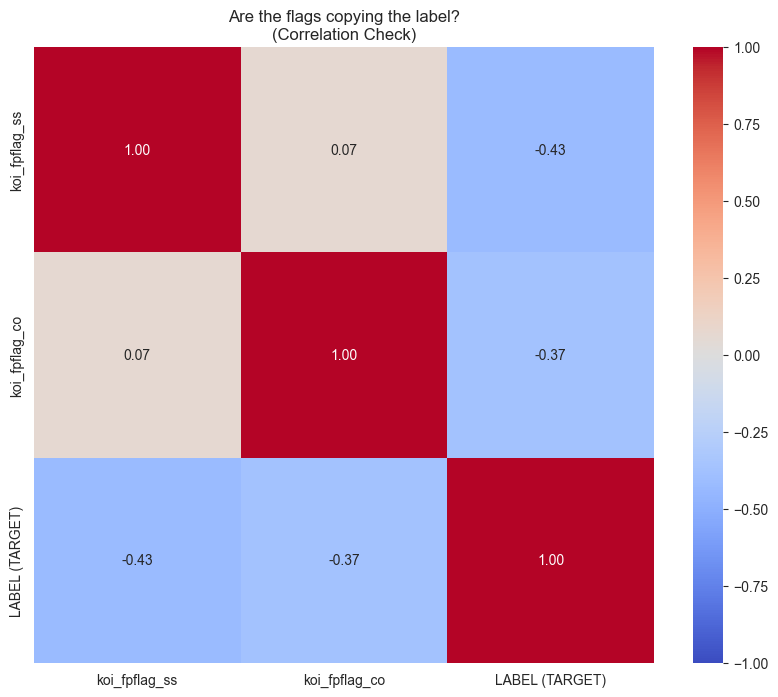

--- Correlation with Label ---
koi_fpflag_ss   -0.425926
koi_fpflag_co   -0.374053
Name: LABEL (TARGET), dtype: float64


In [107]:
def check_leakage_correlation(X, y, feature_names):
    """
    Checks for potential target leakage by measuring correlation between
    "flag" features (e.g., columns containing 'fpflag') and the target label.

    If any flag feature is highly correlated with the label, it may indicate
    that the feature is effectively copying/encoding the target.
    """
    # 1) Build a temporary DataFrame for inspection (needs column names)
    df_check = pd.DataFrame(X, columns=feature_names)
    df_check["LABEL (TARGET)"] = np.asarray(y).ravel()  # ensure 1D target

    # 2) Filter: keep only the flag columns + the target
    # Using a case-insensitive match to be robust (e.g., 'FPFLAG', 'fpFlag', etc.)
    flag_cols = [c for c in feature_names if "fpflag" in c.lower()]

    if len(flag_cols) == 0:
        print("Error: Could not find any columns containing 'fpflag' in their name.")
        return

    cols_to_plot = flag_cols + ["LABEL (TARGET)"]

    # 3) Compute correlation matrix
    correlation_matrix = df_check[cols_to_plot].corr()

    # 4) Visualize correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        vmin=-1,
        vmax=1
    )
    plt.title("Are the flags copying the label?\n(Correlation Check)")
    plt.show()

    # 5) Print each flag column's correlation with the target
    print("--- Correlation with Label ---")
    print(correlation_matrix["LABEL (TARGET)"].drop("LABEL (TARGET)"))


# --- Run the check ---
# Important: make sure feature_names exists (from your earlier cell)
check_leakage_correlation(X_test, y_test, feature_names)


In [108]:
def did_model_outsmart_flags(model, X_test, y_test, feature_names):
    """
    Evaluate whether the model learned signal beyond NASA/Kepler-style flag features
    (e.g., columns containing 'fpflag') by testing two scenarios:

    Scenario A ("Clean imposters"):
      Flags are all zero (looks clean), but the true label is 0 (noise/false positive).
      Success = model predicts 0 despite flags being silent.

    Scenario B ("Flagged planets"):
      At least one flag is on (looks suspicious), but the true label is 1 (planet).
      Success = model predicts 1 despite flags being triggered.

    Notes
    -----
    - IMPORTANT: This function assumes the model's predict() returns class labels (0/1).
      For Keras models returning probabilities, we threshold them.
    - IMPORTANT: If your MLP was trained on scaled data, pass X_test_s here (not X_test).
    """

    # Convert to DataFrame for convenience
    df = pd.DataFrame(X_test, columns=feature_names)

    # Ensure y_test is a clean 1D array
    y_true = np.asarray(y_test).ravel()
    df["True Label"] = y_true

    # Get model predictions (handle sklearn vs Keras)
    if hasattr(model, "predict_proba"):
        # sklearn: probability -> threshold -> class
        y_pred = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
    else:
        # Keras: typically returns probabilities
        pred_raw = model.predict(X_test, verbose=0).ravel()
        # If already 0/1, this still works; if probabilities, it thresholds
        y_pred = (pred_raw >= 0.5).astype(int)

    df["Predicted"] = y_pred

    # 1) Identify flag columns (case-insensitive)
    flag_cols = [c for c in feature_names if "fpflag" in c.lower()]
    if len(flag_cols) == 0:
        print("Error: Could not find any columns containing 'fpflag' in their name.")
        return

    # Sum of flags per row (0 means "no flags triggered")
    df["Sum_Flags"] = df[flag_cols].sum(axis=1)

    # ---------------------------
    # Scenario A: "Clean imposters"
    # Flags say clean (Sum_Flags == 0) but truth is noise (True Label == 0)
    # ---------------------------
    print("--- Scenario A: 'Clean' Imposters (Flags silent, Truth is Noise) ---")
    mask_imposters = (df["Sum_Flags"] == 0) & (df["True Label"] == 0)
    imposters_df = df[mask_imposters]

    total_imposters = len(imposters_df)
    model_success_imposters = (imposters_df["Predicted"] == 0).sum()

    if total_imposters > 0:
        acc = (model_success_imposters / total_imposters) * 100
        print(f"Total 'Clean' Imposters found: {total_imposters}")
        print(f"Model CORRECTLY identified them as noise: {model_success_imposters}")
        print(f"Success Rate: {acc:.1f}%")

        if acc > 50:
            print(">>> CONCLUSION: The model likely learned noise patterns beyond the flags.")
        else:
            print(">>> CONCLUSION: The model may rely heavily on flags in this scenario.")
    else:
        print("No examples found for this scenario.")

    # ---------------------------
    # Scenario B: "Flagged planets"
    # Flags triggered (Sum_Flags > 0) but truth is planet (True Label == 1)
    # ---------------------------
    print("\n--- Scenario B: 'Flagged' Planets (Flags triggered, Truth is Planet) ---")
    mask_wrongly_flagged = (df["Sum_Flags"] > 0) & (df["True Label"] == 1)
    wrong_flag_df = df[mask_wrongly_flagged]

    total_wrong_flags = len(wrong_flag_df)
    model_success_planets = (wrong_flag_df["Predicted"] == 1).sum()

    if total_wrong_flags > 0:
        acc = (model_success_planets / total_wrong_flags) * 100
        print(f"Total Wrongly Flagged Planets found: {total_wrong_flags}")
        print(f"Model CORRECTLY identified them as planets: {model_success_planets}")
        print(f"Success Rate: {acc:.1f}%")

        if acc > 10:
            print(">>> CONCLUSION: The model can sometimes override (potentially over-conservative) flags.")
        else:
            print(">>> CONCLUSION: The model rarely overrides the flags here.")
    else:
        print("No examples found for this scenario (this can be rare).")


# --- Run the check ---
# IMPORTANT:
# - For MLP trained on scaled features, call with X_test_s instead of X_test.
did_model_outsmart_flags(rf_best, X_test, y_test, feature_names)
did_model_outsmart_flags(mlp_best, X_test_s, y_test, feature_names)  # use scaled test set for MLP
did_model_outsmart_flags(knn_best, X_test, y_test, feature_names)


--- Scenario A: 'Clean' Imposters (Flags silent, Truth is Noise) ---
Total 'Clean' Imposters found: 344
Model CORRECTLY identified them as noise: 328
Success Rate: 95.3%
>>> CONCLUSION: The model likely learned noise patterns beyond the flags.

--- Scenario B: 'Flagged' Planets (Flags triggered, Truth is Planet) ---
Total Wrongly Flagged Planets found: 8
Model CORRECTLY identified them as planets: 0
Success Rate: 0.0%
>>> CONCLUSION: The model rarely overrides the flags here.
--- Scenario A: 'Clean' Imposters (Flags silent, Truth is Noise) ---
No examples found for this scenario.

--- Scenario B: 'Flagged' Planets (Flags triggered, Truth is Planet) ---
Total Wrongly Flagged Planets found: 8
Model CORRECTLY identified them as planets: 1
Success Rate: 12.5%
>>> CONCLUSION: The model can sometimes override (potentially over-conservative) flags.
--- Scenario A: 'Clean' Imposters (Flags silent, Truth is Noise) ---
Total 'Clean' Imposters found: 344
Model CORRECTLY identified them as noise: 